## 2. Импорт библиотек и настройка

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Скачиваем стоп-слова для русского языка
nltk.download('stopwords')
nltk.download('punkt')

print("Библиотеки успешно импортированы!")


Библиотеки успешно импортированы!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZubarevVV\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ZubarevVV\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 3. Загрузка и предварительный анализ данных

In [9]:
# Загрузка данных
df = pd.read_excel('training_tmc.xlsx')

# Посмотрим на структуру данных
print("Размер данных:", df.shape)
print("\nПервые 5 строк:")
print(df.head())

print("\nИнформация о данных:")
print(df.info())

# Посмотрим на распределение классов
print("\nРаспределение по классам:")
print(df['Hierarchy_MTR_Name'].value_counts())


Размер данных: (104945, 12)

Первые 5 строк:
   Hierarchy_MTR_Class                        Hierarchy_MTR_Name  CSCD_ID  \
0     4002011102020000  Материалы смазочные мелк.,средн. фасовка  3648365   
1     4002011102020000  Материалы смазочные мелк.,средн. фасовка  3648364   
2     3001010101010200                    Куртки лет муж ЛМ01-01  6087431   
3     3001010101010200                    Куртки лет муж ЛМ01-01  6087428   
4     3001010101010200                    Куртки лет муж ЛМ01-01  6087429   

                   SHORT_NAME/ru_RU  AUTO_SHORT_NAME  \
0  Масло L GEAR GL-4 SYN 75W85 к.4л              NaN   
1  Масло L GEAR GL-4 SYN 75W85 к.1л              NaN   
2                  Куртка ЛМ01-01 2              NaN   
3  Куртка ЛМ01-01 2 104-108/158-164              NaN   
4   Куртка ЛМ01-01 2 96-100/170-176              NaN   

                                     FULL_NAME/ru_RU  AUTO_FULL_NAME  \
0  Масло трансмиссионное LUKOIL GEAR GL-4 SYNTH 7...             NaN   
1  Масло тр

## 4. Предобработка текстовых данных

In [10]:
# Функция для предобработки текста
def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    # Приводим к нижнему регистру
    text = text.lower()
    
    # Удаляем специальные символы, но сохраняем числа и размеры (например, 30х3,4)
    text = re.sub(r'[^\w\s\dх×]', ' ', text)
    
    # Заменяем различные варианты написания 'х' на стандартный
    text = re.sub(r'[х×]', ' x ', text)
    
    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Применяем предобработку к текстовым полям
df['processed_short_name'] = df['SHORT_NAME/ru_RU'].apply(preprocess_text)
df['processed_full_name'] = df['FULL_NAME/ru_RU'].apply(preprocess_text)

# Объединяем короткое и полное название для лучшего контекста
df['combined_text'] = df['processed_short_name'] + ' ' + df['processed_full_name']

# Посмотрим на результат предобработки
print("Примеры обработанных текстов:")
for i in range(3):
    print(f"Оригинал: {df['SHORT_NAME/ru_RU'].iloc[i]}")
    print(f"Обработанный: {df['combined_text'].iloc[i]}")
    print("-" * 50)


Примеры обработанных текстов:
Оригинал: Масло L GEAR GL-4 SYN 75W85 к.4л
Обработанный: масло l gear gl 4 syn 75w85 к 4л масло трансмиссионное lukoil gear gl 4 synth 75w 85 канистра п э 4л
--------------------------------------------------
Оригинал: Масло L GEAR GL-4 SYN 75W85 к.1л
Обработанный: масло l gear gl 4 syn 75w85 к 1л масло трансмиссионное lukoil gear gl 4 synth 75w 85 канистра п э 1л
--------------------------------------------------
Оригинал: Куртка ЛМ01-01 2
Обработанный: куртка лм01 01 2 куртка летняя мужская для защиты от нефти и нефтепродуктов лм01 01 группа ткани 2 сто лукойл 1 6 15 1 1 2023
--------------------------------------------------


## 5. Подготовка данных для модели

In [11]:
# Кодируем целевые метки
label_encoder = LabelEncoder()
df['encoded_labels'] = label_encoder.fit_transform(df['Hierarchy_MTR_Name'])

# Сохраняем mapping для обратного преобразования
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Соответствие меток:")
for label, encoded in label_mapping.items():
    print(f"{encoded}: {label}")

# Подготовка текстовых данных
texts = df['combined_text'].tolist()
labels = df['encoded_labels'].values

# Параметры токенизации
MAX_NB_WORDS = 10000  # Максимальное количество слов в словаре
MAX_SEQUENCE_LENGTH = 100  # Максимальная длина последовательности
EMBEDDING_DIM = 100  # Размерность векторного представления

# Токенизация текстов
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='', lower=False)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Паддинг последовательностей до одинаковой длины
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Подготовка меток
y = to_categorical(labels)
num_classes = y.shape[1]

print(f"Размерность данных: {X.shape}")
print(f"Количество классов: {num_classes}")
print(f"Размер словаря: {len(tokenizer.word_index)}")


Соответствие меток:
0: 3аготовки трубные
1: DIN-рейки
2: USB-Токены
3: [На Блок] Отводы для трубопроводов без покрытия
4: [На Блок] Тройники для трубопроводов без покрытия
5: [На Блок] пластификаторы
6: Абразивы
7: Автобусы
8: Автомобили грузовые
9: Автомобили легковые
10: Автомобили пожарные
11: Автохимические жидкости (не нефтехимия)
12: Адаптеры (перех.) трубопр. по чертежу
13: Адаптеры (перех.) трубопр. стандартные
14: Адаптеры (перех.) трубопр. фирменные
15: Адаптеры для электросети
16: Адаптеры компьютерные
17: Аксессуары компьютерные
18: Анализаторы лабораторные
19: Анкеры
20: Антенны
21: Аппаратура для контроля скважин
22: Аппараты воздушного охлаждения (АВО)
23: Аппараты емкостные вертикал. ВПП
24: Аппараты емкостные вертикал. ВЭЭ
25: Аппараты емкостные вертикал. прочие
26: Аппараты емкостные горизонт. ГЭЭ
27: Аппараты емкостные горизонт. прочие
28: Аппараты и установки сушильные
29: Аппараты телефонные (телефоны)
30: Арматура для ВЛ
31: Арматура к приборам контроля давления
3

## 6. Анализ распределения классов и решение проблемы малых классов

In [13]:
# Анализируем распределение классов
class_distribution = df['Hierarchy_MTR_Name'].value_counts()
print("Распределение классов:")
print(class_distribution)

# Определяем порог для малых классов
MIN_SAMPLES_PER_CLASS = 2  # Минимальное количество примеров для стратификации

# Находим классы с достаточным количеством примеров
valid_classes = class_distribution[class_distribution >= MIN_SAMPLES_PER_CLASS].index
small_classes = class_distribution[class_distribution < MIN_SAMPLES_PER_CLASS].index

print(f"\nКлассы с достаточным количеством данных ({len(valid_classes)}):")
print(valid_classes.tolist())

print(f"\nМелкие классы (будут исключены из обучения) ({len(small_classes)}):")
print(small_classes.tolist())

# Фильтруем данные, оставляя только классы с достаточным количеством примеров
df_filtered = df[df['Hierarchy_MTR_Name'].isin(valid_classes)].copy()

print(f"\nИсходный размер датасета: {len(df)}")
print(f"Размер после фильтрации: {len(df_filtered)}")
print(f"Удалено записей: {len(df) - len(df_filtered)}")

# Перекодируем метки для отфильтрованных данных
label_encoder = LabelEncoder()
df_filtered['encoded_labels'] = label_encoder.fit_transform(df_filtered['Hierarchy_MTR_Name'])

# Сохраняем mapping для обратного преобразования
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nСоответствие меток после фильтрации:")
for label, encoded in label_mapping.items():
    print(f"{encoded}: {label} (примеров: {class_distribution[label]})")


Распределение классов:
Hierarchy_MTR_Name
Фильтры автомобильные                       8579
Узлы и компл. д/нест. оборуд. по чертежу    6057
Запчасти и узлы автомобил.трансп.прочие     5152
Узлы, детали оборуд. насосного прочие       4821
Узлы и компл. д/нест. оборуд. фирменные     3665
                                            ... 
Полиспасты                                     1
ПС сканирования и распознавания док.           1
Полуботинки дем. муж. НмСжСмЭс                 1
Хомуты автомобильные                           1
Отстойники нефти ОГ                            1
Name: count, Length: 1645, dtype: int64

Классы с достаточным количеством данных (1502):
['Фильтры автомобильные', 'Узлы и компл. д/нест. оборуд. по чертежу', 'Запчасти и узлы автомобил.трансп.прочие', 'Узлы, детали оборуд. насосного прочие', 'Узлы и компл. д/нест. оборуд. фирменные', 'Изделия и детали изготавливаемые', 'Узлы, детали оборуд. компрес. прочие', 'Узлы, детали оборуд. насос. по чертежу', 'Насосы скважин

## 7. Подготовка текстовых данных для отфильтрованного датасета

In [14]:
# Подготовка текстовых данных для отфильтрованного датасета
texts = df_filtered['combined_text'].tolist()
labels = df_filtered['encoded_labels'].values

# Параметры токенизации (можно уменьшить для меньшего датасета)
MAX_NB_WORDS = 5000  # Уменьшаем размер словаря для меньшего датасета
MAX_SEQUENCE_LENGTH = 50   # Уменьшаем длину последовательности
EMBEDDING_DIM = 100

# Токенизация текстов
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='', lower=False)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Паддинг последовательностей до одинаковой длины
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Подготовка меток
y = to_categorical(labels)
num_classes = y.shape[1]

print(f"Размерность данных: {X.shape}")
print(f"Количество классов: {num_classes}")
print(f"Размер словаря: {len(tokenizer.word_index)}")
print(f"Минимальное количество примеров в классе: {np.min(np.sum(y, axis=0))}")


Размерность данных: (104802, 50)
Количество классов: 1502
Размер словаря: 77892
Минимальное количество примеров в классе: 2.0


## 8. Стратифицированное разделение данных с проверкой

In [8]:
# Дополнительное уменьшение параметров для экономии памяти
MAX_NB_WORDS = 4000   # Еще больше уменьшаем словарь
MAX_SEQUENCE_LENGTH = 40    # Еще больше уменьшаем длину последовательности

# Пересоздаем X с новыми параметрами
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(f"Новая размерность данных: {X.shape}")


Новая размерность данных: (104802, 40)


In [16]:
def simple_split(X, y, test_size=0.15, val_size=0.15, random_state=42):
    """
    Простое разделение без стратификации (менее оптимально, но надежно)
    """
    # Сначала разделяем на train и temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(test_size + val_size), random_state=random_state
    )
    
    # Затем разделяем temp на val и test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=test_size/(test_size + val_size), random_state=random_state
    )
    
    print(f"Размеры выборок:")
    print(f"Обучающая: {X_train.shape[0]} примеров")
    print(f"Валидационная: {X_val.shape[0]} примеров")
    print(f"Тестовая: {X_test.shape[0]} примеров")
    
    # Проверяем распределение классов
    print("\nРаспределение классов (предупреждение: без стратификации):")
    train_classes = np.unique(np.argmax(y_train, axis=1))
    val_classes = np.unique(np.argmax(y_val, axis=1))
    test_classes = np.unique(np.argmax(y_test, axis=1))
    
    print(f"Обучающая: {len(train_classes)} классов")
    print(f"Валидационная: {len(val_classes)} классов") 
    print(f"Тестовая: {len(test_classes)} классов")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Используем простой метод если другие не работают
X_train, X_val, X_test, y_train, y_val, y_test = simple_split(X, y)





Размеры выборок:
Обучающая: 73361 примеров
Валидационная: 15720 примеров
Тестовая: 15721 примеров

Распределение классов (предупреждение: без стратификации):
Обучающая: 1473 классов
Валидационная: 1068 классов
Тестовая: 1060 классов


## 9. Альтернативное решение: увеличение веса малых классов

In [25]:
# Если после фильтрации остались классы с малым количеством примеров, 
# можно использовать взвешивание классов

from sklearn.utils.class_weight import compute_class_weight

# Вычисляем веса классов для компенсации дисбаланса
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)

# Создаем словарь весов для Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Веса классов для компенсации дисбаланса:")
for cls, weight in class_weight_dict.items():
    class_name = label_encoder.inverse_transform([cls])[0]
    print(f"  {class_name}: {weight:.2f}")


NameError: name 'labels' is not defined

In [18]:
vocab_size = len(tokenizer.word_index) + 1 

In [19]:
# Диагностика проблемы
print("=== ДИАГНОСТИКА ПРОБЛЕМЫ ===")
print(f"Максимальный индекс в данных: {np.max(X_train)}")
print(f"Размер словаря (vocab_size): {vocab_size}")
print(f"MAX_NB_WORDS: {MAX_NB_WORDS}")

# Проверяем все данные на наличие индексов вне словаря
def check_indices(X_data, vocab_size, data_name):
    max_idx = np.max(X_data)
    min_idx = np.min(X_data)
    out_of_vocab = np.sum(X_data >= vocab_size)
    print(f"{data_name}: min={min_idx}, max={max_idx}, out_of_vocab={out_of_vocab}")

print("\nПроверка индексов:")
check_indices(X_train, vocab_size, "X_train")
check_indices(X_val, vocab_size, "X_val") 
check_indices(X_test, vocab_size, "X_test")

=== ДИАГНОСТИКА ПРОБЛЕМЫ ===
Максимальный индекс в данных: 4999
Размер словаря (vocab_size): 77893
MAX_NB_WORDS: 5000

Проверка индексов:
X_train: min=0, max=4999, out_of_vocab=0
X_val: min=0, max=4999, out_of_vocab=0
X_test: min=0, max=4999, out_of_vocab=0


## 10. Создание модели CNN + LSTM

In [20]:
def create_cnn_lstm_model_fixed(vocab_size, embedding_dim, max_sequence_length, num_classes):
    model = Sequential()
    
    # Слой Embedding - исправляем input_dim
    model.add(Embedding(
        input_dim=vocab_size + 1,  # +1 потому что индексация с 0
        output_dim=embedding_dim,
        input_length=max_sequence_length,
        name='embedding'
    ))
    
    # Сверточные слои
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(2))
    
    model.add(Conv1D(32, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(2))
    
    # Рекуррентный слой
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.1))
    
    # Полносвязные слои
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    
    # Выходной слой
    model.add(Dense(num_classes, activation='softmax'))
    
    # Компиляция модели
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Проверяем размерности данных
print("Проверка размерностей данных:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"Vocabulary size: {vocab_size}")
print(f"Number of classes: {num_classes}")

# Проверяем диапазон значений в X_train
print(f"\nДиапазон значений в X_train: от {np.min(X_train)} до {np.max(X_train)}")

# Создаем модель с правильными параметрами
model = create_cnn_lstm_model_fixed(vocab_size, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, num_classes)

print("\nАрхитектура модели:")
model.summary()

Проверка размерностей данных:
X_train shape: (73361, 50)
y_train shape: (73361, 1502)
X_val shape: (15720, 50)
y_val shape: (15720, 1502)
Vocabulary size: 77893
Number of classes: 1502

Диапазон значений в X_train: от 0 до 4999


c:\Users\ZubarevVV\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Архитектура модели:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [100]:
# Если предыдущая модель не работает, создадим более простую
def create_simple_model(vocab_size, embedding_dim, max_sequence_length, num_classes):
    model = Sequential()
    
    # Более простой embedding слой
    model.add(Embedding(
        input_dim=vocab_size + 1,
        output_dim=embedding_dim,
        input_length=max_sequence_length,
        mask_zero=True  # Игнорировать нулевые padding значения
    ))
    
    # Глобальный пулинг вместо сверток
    model.add(GlobalMaxPooling1D())
    
    # Всего один скрытый слой
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    
    # Выходной слой
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Пробуем создать упрощенную модель
print("Создаем упрощенную модель...")
simple_model = create_simple_model(vocab_size, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, num_classes)
simple_model.summary()


Создаем упрощенную модель...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 11. Обучение модели с учетом дисбаланса (измененный блок обучения)

In [21]:
# Дополнительная проверка данных
def validate_data(X_train, y_train, X_val, y_val, tokenizer):
    """Проверка целостности данных перед обучением"""
    
    # Проверяем, что все индексы в пределах словаря
    max_index = np.max(X_train)
    vocab_size_actual = len(tokenizer.word_index) + 1  # +1 для padding
    print(f"Максимальный индекс в данных: {max_index}")
    print(f"Размер словаря: {vocab_size_actual}")
    
    if max_index >= vocab_size_actual:
        print(f"ОШИБКА: Найден индекс {max_index}, но размер словаря только {vocab_size_actual}")
        # Исправляем проблему
        X_train = np.clip(X_train, 0, vocab_size_actual - 1)
        X_val = np.clip(X_val, 0, vocab_size_actual - 1)
        print("Данные исправлены через clipping")
    
    # Проверяем соответствие размерностей
    assert X_train.shape[0] == y_train.shape[0], "Несоответствие размеров X_train и y_train"
    assert X_val.shape[0] == y_val.shape[0], "Несоответствие размеров X_val и y_val"
    
    # Проверяем, что y содержит вероятности
    y_sum = np.sum(y_train, axis=1)
    print(f"Сумма по строкам y_train: min={np.min(y_sum):.2f}, max={np.max(y_sum):.2f}")
    
    return X_train, X_val

# Проверяем и исправляем данные если нужно
X_train, X_val = validate_data(X_train, y_train, X_val, y_val, tokenizer)


Максимальный индекс в данных: 4999
Размер словаря: 77893
Сумма по строкам y_train: min=1.00, max=1.00


#### Обучение минимальной модели

In [15]:
# Callback для ранней остановки
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Функция для безопасного обучения
def safe_model_fit(model, X_train, y_train, X_val, y_val, class_weight_dict=None):
    try:
        print("Начинаем обучение модели...")
        
        history = model.fit(
            X_train, y_train,
            batch_size=16,
            epochs=50,  # Уменьшаем количество эпох для теста
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            class_weight=class_weight_dict,
            verbose=1
        )
        return history, True
    except Exception as e:
        print(f"Ошибка при обучении: {e}")
        print("Пробуем альтернативные настройки...")
        return None, False

# Пробуем обучить упрощенную модель сначала
print("=== Тестируем упрощенную модель ===")
history_simple, success_simple = safe_model_fit(
    simple_model, X_train, y_train, X_val, y_val, class_weight_dict
)

if success_simple:
    print("Упрощенная модель успешно обучена!")
    model = simple_model  # Используем упрощенную модель
    history = history_simple
else:
    print("Пробуем оригинальную модель...")
    # Пробуем оригинальную модель с меньшим batch size
    try:
        history = model.fit(
            X_train, y_train,
            batch_size=8,  # Еще меньше batch size
            epochs=50,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            class_weight=class_weight_dict,
            verbose=1
        )
    except Exception as e:
        print(f"Ошибка с оригинальной моделью: {e}")
        print("Создаем минимальную модель...")
        
        # Создаем минимальную модель
        minimal_model = Sequential([
            Embedding(vocab_size + 1, 50, input_length=MAX_SEQUENCE_LENGTH),
            GlobalMaxPooling1D(),
            Dense(16, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])
        minimal_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        history = minimal_model.fit(
            X_train, y_train,
            batch_size=8,
            epochs=50,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            verbose=1
        )
        model = minimal_model

print("Обучение завершено!")



=== Тестируем упрощенную модель ===
Начинаем обучение модели...
Epoch 1/50


c:\Users\ZubarevVV\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


3931/3931 ━━━━━━━━━━━━━━━━━━━━ 398s 101ms/step - accuracy: 0.3357 - loss: 7.0415 - val_accuracy: 0.6061 - val_loss: 2.7479
Epoch 2/50
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 383s 97ms/step - accuracy: 0.5774 - loss: 5.7132 - val_accuracy: 0.7266 - val_loss: 1.6898
Epoch 3/50
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 384s 98ms/step - accuracy: 0.6571 - loss: 4.7633 - val_accuracy: 0.7781 - val_loss: 1.2467
Epoch 4/50
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 381s 97ms/step - accuracy: 0.6996 - loss: 4.1390 - val_accuracy: 0.7967 - val_loss: 1.1242
Epoch 5/50
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 387s 98ms/step - accuracy: 0.7289 - loss: 3.7009 - val_accuracy: 0.8186 - val_loss: 0.9948
Epoch 6/50
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 385s 98ms/step - accuracy: 0.7452 - loss: 3.4043 - val_accuracy: 0.8307 - val_loss: 0.9491
Epoch 7/50
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 386s 98ms/step - accuracy: 0.7597 - loss: 3.1866 - val_accuracy: 0.8413 - val_loss: 0.9060
Epoch 8/50
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 384s 98ms/step - accuracy: 0.7702 - l

#### Обучение полной модели

In [22]:

# Callback для ранней остановки
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Пробуем оригинальную модель...")
    # Пробуем оригинальную модель с меньшим batch size
try:
        history = model.fit(
            X_train, y_train,
            batch_size=16,  # Еще меньше batch size
            epochs=50,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            class_weight=class_weight_dict,
            verbose=1
        )
except Exception as e:
        print(f"Ошибка с оригинальной моделью: {e}")
        print("Создаем минимальную модель...")
        
        # Создаем минимальную модель
        minimal_model = Sequential([
            Embedding(vocab_size + 1, 50, input_length=MAX_SEQUENCE_LENGTH),
            GlobalMaxPooling1D(),
            Dense(16, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])
        minimal_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        history = minimal_model.fit(
            X_train, y_train,
            batch_size=8,
            epochs=50,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            verbose=1
        )
        model = minimal_model

print("Обучение завершено!")

Пробуем оригинальную модель...
Epoch 1/50
4586/4586 ━━━━━━━━━━━━━━━━━━━━ 491s 106ms/step - accuracy: 0.0110 - loss: 7.3323 - val_accuracy: 0.0214 - val_loss: 5.7513
Epoch 2/50
4586/4586 ━━━━━━━━━━━━━━━━━━━━ 477s 104ms/step - accuracy: 0.0766 - loss: 6.9700 - val_accuracy: 0.1588 - val_loss: 4.8050
Epoch 3/50
4586/4586 ━━━━━━━━━━━━━━━━━━━━ 480s 105ms/step - accuracy: 0.1261 - loss: 6.7440 - val_accuracy: 0.2653 - val_loss: 4.2082
Epoch 4/50
4586/4586 ━━━━━━━━━━━━━━━━━━━━ 471s 103ms/step - accuracy: 0.1724 - loss: 6.5464 - val_accuracy: 0.3013 - val_loss: 3.7961
Epoch 5/50
4586/4586 ━━━━━━━━━━━━━━━━━━━━ 479s 104ms/step - accuracy: 0.1960 - loss: 6.3990 - val_accuracy: 0.2948 - val_loss: 4.0174
Epoch 6/50
4586/4586 ━━━━━━━━━━━━━━━━━━━━ 463s 101ms/step - accuracy: 0.2135 - loss: 6.2525 - val_accuracy: 0.3721 - val_loss: 3.4459
Epoch 7/50
4586/4586 ━━━━━━━━━━━━━━━━━━━━ 460s 100ms/step - accuracy: 0.2460 - loss: 6.1218 - val_accuracy: 0.4224 - val_loss: 3.2630
Epoch 8/50
4586/4586 ━━━━━━━━━━

### 11.1. Визуализация процесса обучения

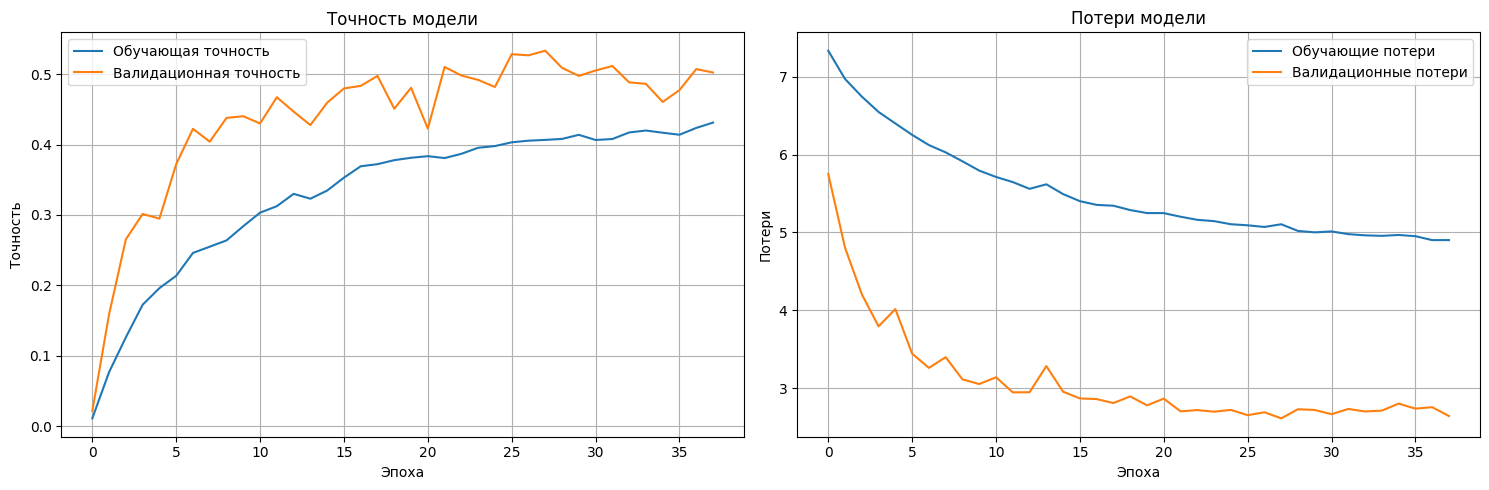

In [23]:
# Функция для построения графиков обучения
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # График точности
    ax1.plot(history.history['accuracy'], label='Обучающая точность')
    ax1.plot(history.history['val_accuracy'], label='Валидационная точность')
    ax1.set_title('Точность модели')
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Точность')
    ax1.legend()
    ax1.grid(True)
    
    # График потерь
    ax2.plot(history.history['loss'], label='Обучающие потери')
    ax2.plot(history.history['val_loss'], label='Валидационные потери')
    ax2.set_title('Потери модели')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('Потери')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Строим графики
plot_training_history(history)


### 11.2 Оценка модели

In [24]:
# Оценка на тестовых данных
print("=== ОЦЕНКА МОДЕЛИ НА ТЕСТОВЫХ ДАННЫХ ===")

# Используем правильные классы из label_encoder
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Точность на тестовых данных: {test_accuracy:.4f}")

# Предсказания
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Получаем актуальные классы из данных
unique_true = np.unique(y_true_classes)
unique_pred = np.unique(y_pred_classes)
all_classes = np.union1d(unique_true, unique_pred)

print(f"Уникальные классы в true: {len(unique_true)}")
print(f"Уникальные классы в pred: {len(unique_pred)}")
print(f"Все классы для отчета: {len(all_classes)}")

# Создаем правильные названия классов только для существующих классов
available_classes = label_encoder.classes_[all_classes] if len(all_classes) <= len(label_encoder.classes_) else [f"Class_{i}" for i in all_classes]

# Отчет о классификации с правильными labels
print("\nОтчет о классификации:")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    labels=all_classes,
    target_names=available_classes,
    zero_division=0
))




=== ОЦЕНКА МОДЕЛИ НА ТЕСТОВЫХ ДАННЫХ ===
Точность на тестовых данных: 0.5314
Уникальные классы в true: 1060
Уникальные классы в pred: 410
Все классы для отчета: 1099

Отчет о классификации:
                                                     precision    recall  f1-score   support

                                         USB-Токены       0.00      0.00      0.00         3
    [На Блок] Отводы для трубопроводов без покрытия       0.00      0.00      0.00         1
                                           Абразивы       0.00      0.00      0.00         0
                                Автомобили легковые       0.00      0.00      0.00         2
                                Автомобили пожарные       0.00      0.00      0.00         2
              Адаптеры (перех.) трубопр. по чертежу       0.00      0.00      0.00         1
               Адаптеры (перех.) трубопр. фирменные       0.57      0.57      0.57         7
                              Адаптеры компьютерные       0.00   

## 12. Загрузка моделей

In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import json
import re

def load_tmc_classification_model(model_path='tmc_classification_model.h5',
                                 tokenizer_path='tokenizer.pickle',
                                 label_encoder_path='label_encoder.pickle',
                                 params_path='model_params.json'):
    """
    Загружает все компоненты модели для классификации ТМЦ после перезапуска ноутбука
    
    Returns:
    - model: загруженная модель
    - tokenizer: загруженный токенизатор
    - label_encoder: загруженный кодировщик меток
    - params: параметры модели
    - preprocess_text: функция предобработки текста
    """
    
    print("=== ЗАГРУЗКА МОДЕЛИ КЛАССИФИКАЦИИ ТМЦ ===")
    
    # Функция предобработки текста
    def preprocess_text(text):
        if pd.isna(text):
            return ""
        
        text = str(text).lower()
        text = re.sub(r'[^\w\s\dх×]', ' ', text)
        text = re.sub(r'[х×]', ' x ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    try:
        # Загружаем параметры модели
        print("1. Загрузка параметров модели...")
        with open(params_path, 'r', encoding='utf-8') as f:
            params = json.load(f)
        
        MAX_NB_WORDS = params['MAX_NB_WORDS']
        MAX_SEQUENCE_LENGTH = params['MAX_SEQUENCE_LENGTH']
        EMBEDDING_DIM = params.get('EMBEDDING_DIM', 64)
        vocab_size = params.get('vocab_size', MAX_NB_WORDS)
        
        print(f"   ✓ MAX_NB_WORDS: {MAX_NB_WORDS}")
        print(f"   ✓ MAX_SEQUENCE_LENGTH: {MAX_SEQUENCE_LENGTH}")
        print(f"   ✓ EMBEDDING_DIM: {EMBEDDING_DIM}")
        print(f"   ✓ vocab_size: {vocab_size}")
        
    except Exception as e:
        print(f"   ✗ Ошибка загрузки параметров: {e}")
        # Значения по умолчанию
        MAX_NB_WORDS = 5000
        MAX_SEQUENCE_LENGTH = 50
        EMBEDDING_DIM = 64
        vocab_size = MAX_NB_WORDS
        params = {
            'MAX_NB_WORDS': MAX_NB_WORDS,
            'MAX_SEQUENCE_LENGTH': MAX_SEQUENCE_LENGTH,
            'EMBEDDING_DIM': EMBEDDING_DIM,
            'vocab_size': vocab_size
        }
        print("   ⚠ Используются параметры по умолчанию")
    
    try:
        # Загружаем модель
        print("2. Загрузка модели Keras...")
        model = load_model(model_path)
        print(f"   ✓ Модель загружена: {model_path}")
        print(f"   ✓ Архитектура: {model.summary()}")
        
    except Exception as e:
        print(f"   ✗ Ошибка загрузки модели: {e}")
        model = None
    
    try:
        # Загружаем токенизатор
        print("3. Загрузка токенизатора...")
        with open(tokenizer_path, 'rb') as f:
            tokenizer = pickle.load(f)
        print(f"   ✓ Токенизатор загружен: {len(tokenizer.word_index)} слов в словаре")
        
    except Exception as e:
        print(f"   ✗ Ошибка загрузки токенизатора: {e}")
        tokenizer = None
    
    try:
        # Загружаем label encoder
        print("4. Загрузка LabelEncoder...")
        with open(label_encoder_path, 'rb') as f:
            label_encoder = pickle.load(f)
        print(f"   ✓ LabelEncoder загружен: {len(label_encoder.classes_)} классов")
        
    except Exception as e:
        print(f"   ✗ Ошибка загрузки LabelEncoder: {e}")
        label_encoder = None
    
    # Создаем словарь с результатами
    components = {
        'model': model,
        'tokenizer': tokenizer,
        'label_encoder': label_encoder,
        'params': params,
        'preprocess_text': preprocess_text,
        'MAX_NB_WORDS': MAX_NB_WORDS,
        'MAX_SEQUENCE_LENGTH': MAX_SEQUENCE_LENGTH,
        'EMBEDDING_DIM': EMBEDDING_DIM,
        'vocab_size': vocab_size
    }
    
    print("\n✓ Все компоненты успешно загружены!")
    return components

# Загружаем все компоненты
try:
    components = load_tmc_classification_model()
    
    # Распаковываем компоненты в глобальные переменные
    model = components['model']
    tokenizer = components['tokenizer']
    label_encoder = components['label_encoder']
    params = components['params']
    preprocess_text = components['preprocess_text']
    MAX_NB_WORDS = components['MAX_NB_WORDS']
    MAX_SEQUENCE_LENGTH = components['MAX_SEQUENCE_LENGTH']
    EMBEDDING_DIM = components['EMBEDDING_DIM']
    vocab_size = components['vocab_size']
    
    print("\n✓ Глобальные переменные установлены!")
    print("Доступные переменные: model, tokenizer, label_encoder, preprocess_text")
    print(f"Параметры: MAX_SEQUENCE_LENGTH={MAX_SEQUENCE_LENGTH}, vocab_size={vocab_size}")
    
except Exception as e:
    print(f"✗ Критическая ошибка при загрузке: {e}")
    print("⚠ Проверьте наличие файлов:")
    print("  - tmc_classification_final_model.h5")
    print("  - final_tokenizer.pickle") 
    print("  - final_label_encoder.pickle")
    print("  - model_params.json")

c:\Users\ZubarevVV\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


=== ЗАГРУЗКА МОДЕЛИ КЛАССИФИКАЦИИ ТМЦ ===
1. Загрузка параметров модели...
   ✓ MAX_NB_WORDS: 4000
   ✓ MAX_SEQUENCE_LENGTH: 40
   ✓ EMBEDDING_DIM: 100
   ✓ vocab_size: 4000
2. Загрузка модели Keras...
   ✓ Модель загружена: tmc_classification_model.h5


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 100)        │     7,789,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 100)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1502)           │        49,566 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,842,200 (29.92 MB)

 Trainable params: 7,842,198 (29.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

   ✓ Архитектура: None
3. Загрузка токенизатора...
   ✓ Токенизатор загружен: 77892 слов в словаре
4. Загрузка LabelEncoder...
   ✓ LabelEncoder загружен: 1502 классов

✓ Все компоненты успешно загружены!

✓ Глобальные переменные установлены!
Доступные переменные: model, tokenizer, label_encoder, preprocess_text
Параметры: MAX_SEQUENCE_LENGTH=40, vocab_size=4000


### 12.1. Тестирование загруженной модели

In [37]:
def predict_tmc_category(text, return_details=False):
    """
    Универсальная функция для предсказания категории ТМЦ
    
    Parameters:
    - text: текст для классификации
    - return_details: если True, возвращает детальную информацию
    
    Returns:
    - Если return_details=False: (class_code, confidence)
    - Если return_details=True: словарь с деталями
    """
    
    if model is None or tokenizer is None or label_encoder is None:
        raise ValueError("Модель не загружена. Вызовите load_tmc_classification_model() сначала.")
    
    # Предобработка
    processed_text = preprocess_text(text)
    
    # Токенизация
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Обрезаем индексы
    padded_sequence = np.clip(padded_sequence, 0, vocab_size - 1)
    
    # Предсказание
    prediction = model.predict(padded_sequence, verbose=0)
    predicted_class_idx = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)
    
    # Декодируем класс
    original_class_idx = label_encoder.inverse_transform([predicted_class_idx])[0]
    
    if not return_details:
        return original_class_idx, round(confidence, 4)
    else:
        confidence_status = 'ВЫСОКАЯ' if confidence > 0.7 else 'СРЕДНЯЯ' if confidence > 0.5 else 'НИЗКАЯ'
        
        return {
            'original_text': text,
            'processed_text': processed_text,
            'class_code': original_class_idx,
            'class_name': f"Class_{original_class_idx}",
            'confidence': round(confidence, 4),
            'confidence_status': confidence_status,
            'all_predictions': prediction[0]
        }

def batch_predict_tmc(texts):
    """
    Пакетная классификация списка текстов
    """
    results = []
    for text in texts:
        try:
            result = predict_tmc_category(text, return_details=True)
            results.append(result)
        except Exception as e:
            results.append({
                'original_text': text,
                'class_code': None,
                'class_name': 'ОШИБКА',
                'confidence': 0.0,
                'confidence_status': f'ОШИБКА: {str(e)}'
            })
    
    return pd.DataFrame(results)

# Тестируем загруженную модель
if all([model is not None, tokenizer is not None, label_encoder is not None]):
    print("\n=== ТЕСТИРОВАНИЕ ЗАГРУЖЕННОЙ МОДЕЛИ ===")
    
    test_texts = [
        "Масло трансмиссионное LUKOIL GEAR GL-4",
        "Труба полипропиленовая PPR 20мм",
        "Куртка летняя защитная",
        "Тестовый товар для проверки"
    ]
    
    for text in test_texts:
        try:
            class_code, confidence = predict_tmc_category(text)
            print(f"Текст: '{text}'")
            print(f"→ Класс: {class_code}, Уверенность: {confidence}")
            print("-" * 50)
        except Exception as e:
            print(f"Ошибка для '{text}': {e}")



=== ТЕСТИРОВАНИЕ ЗАГРУЖЕННОЙ МОДЕЛИ ===
Текст: 'Масло трансмиссионное LUKOIL GEAR GL-4'
→ Класс: Материалы смазочные мелк.,средн. фасовка, Уверенность: 0.9998999834060669
--------------------------------------------------
Текст: 'Труба полипропиленовая PPR 20мм'
→ Класс: Узлы и детали оборуд. емкостного прочие, Уверенность: 0.12520000338554382
--------------------------------------------------
Текст: 'Куртка летняя защитная'
→ Класс: Крестовины канализационные, Уверенность: 0.009700000286102295
--------------------------------------------------
Текст: 'Тестовый товар для проверки'
→ Класс: Пряжки, скобы, Уверенность: 0.07199999690055847
--------------------------------------------------


## 13. Функция для предсказания на новых данных

### 13.1 Функция для предсказания на новых данных из кода

In [15]:
def predict_category(text, model, tokenizer, label_encoder, max_sequence_length):
    """
    Функция для предсказания категории нового текста
    """
    # Предобработка текста
    processed_text = preprocess_text(text)
    
    # Токенизация и паддинг
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    
    # Предсказание
    prediction = model.predict(padded_sequence, verbose=0)
    predicted_class_idx = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)
    
    # Преобразование обратно в текстовую метку
    predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
    
    return predicted_class, confidence

# Тестирование функции на примерах
test_texts = [
    "Масло трансмиссионное синтетическое 75W90",
    "Труба полипропиленовая PPR 20мм",
    "Куртка летняя защитная",
    "Теплообменник стальной"
]

print("Тестирование предсказаний:")
print("=" * 60)
for text in test_texts:
    category, confidence = predict_category(text, model, tokenizer, label_encoder, MAX_SEQUENCE_LENGTH)
    print(f"Текст: '{text}'")
    print(f"Предсказанная категория: {category}")
    print(f"Уверенность: {confidence:.4f}")
    print("-" * 40)


Тестирование предсказаний:
Текст: 'Масло трансмиссионное синтетическое 75W90'
Предсказанная категория: Материалы смазочные мелк.,средн. фасовка
Уверенность: 0.9474
----------------------------------------
Текст: 'Труба полипропиленовая PPR 20мм'
Предсказанная категория: Узлы и детали оборуд. емкостного прочие
Уверенность: 0.1252
----------------------------------------
Текст: 'Куртка летняя защитная'
Предсказанная категория: Крестовины канализационные
Уверенность: 0.0097
----------------------------------------
Текст: 'Теплообменник стальной'
Предсказанная категория: Теплообменники пластинчатые
Уверенность: 0.7751
----------------------------------------


### 13.1 Функция для предсказания на новых данных из EXCEL

In [10]:
# Создаем mapping между кодами классов и их названиями из исходного датафрейма
def create_class_mapping_from_df(df):
    """
    Создает mapping между Hierarchy_MTR_Class и Hierarchy_MTR_Name из исходного датафрейма
    """
    # Берем уникальные пары код-название
    class_mapping = df[['Hierarchy_MTR_Class', 'Hierarchy_MTR_Name']].drop_duplicates()
    
    # Создаем словарь для быстрого доступа
    class_code_to_name = dict(zip(class_mapping['Hierarchy_MTR_Class'], class_mapping['Hierarchy_MTR_Name']))
    class_name_to_code = dict(zip(class_mapping['Hierarchy_MTR_Name'], class_mapping['Hierarchy_MTR_Class']))
    
    print(f"Создан mapping классов:")
    print(f"  - Уникальных кодов: {len(class_code_to_name)}")
    print(f"  - Уникальных названий: {len(class_name_to_code)}")
    
    # Покажем несколько примеров
    print("Примеры mapping:")
    for i, (code, name) in enumerate(list(class_code_to_name.items())[:5]):
        print(f"  {code} → {name}")
    
    return class_code_to_name, class_name_to_code

# Создаем mapping
if 'df' in locals():
    class_code_to_name, class_name_to_code = create_class_mapping_from_df(df)
else:
    print("⚠ Исходный датафрейм df не найден")
    class_code_to_name, class_name_to_code = {}, {}

Создан mapping классов:
  - Уникальных кодов: 1645
  - Уникальных названий: 1645
Примеры mapping:
  4002011102020000 → Материалы смазочные мелк.,средн. фасовка
  3001010101010200 → Куртки лет муж ЛМ01-01
  2013050101020000 → Трубы полимерные напорные фирменные
  2002130401030000 → Теплообменники кожухотрубчатые
  3001010201010100 → Костюмы лет муж ЛМ03-01


In [7]:
def classify_excel_file_loaded(input_file_path, output_file_path, 
                              text_column_name=None,
                              sheet_name=0):
    """
    Улучшенная функция для классификации Excel файла с загруженной моделью
    Сохраняет все исходные колонки в конце результата
    
    Parameters:
    - input_file_path: путь к входному Excel файлу
    - output_file_path: путь для сохранения результатов
    - text_column_name: название столбца с текстом (если None, определит автоматически)
    - sheet_name: название листа или номер листа
    """
    
    if model is None:
        raise ValueError("Модель не загружена!")
    
    print(f"=== КЛАССИФИКАЦИЯ EXCEL ФАЙЛА ===")
    print(f"Входной файл: {input_file_path}")
    
    try:
        # Загружаем данные
        df_input = pd.read_excel(input_file_path, sheet_name=sheet_name)
        print(f"✓ Загружено {len(df_input)} строк из файла")
        print(f"✓ Исходные колонки: {list(df_input.columns)}")
        
        # Определяем столбец с текстом
        if text_column_name and text_column_name in df_input.columns:
            text_column = text_column_name
            print(f"✓ Используем указанный столбец: '{text_column}'")
        else:
            # Автопоиск столбца с текстом
            text_columns = []
            for col in df_input.columns:
                col_lower = col.lower()
                if any(keyword in col_lower for keyword in ['наименование', 'name', 'описание', 'description', 'текст', 'text', 'товар', 'product']):
                    text_columns.append(col)
            
            if text_columns:
                text_column = text_columns[0]
                print(f"✓ Автоопределен столбец: '{text_column}'")
            else:
                text_column = df_input.columns[0]
                print(f"⚠ Столбец не найден, используем первый: '{text_column}'")
        
        # Классификация
        results = []
        for idx, row in df_input.iterrows():
            text = str(row[text_column]) if pd.notna(row[text_column]) else ""
            
            if not text.strip():
                result_row = {
                    'Исходное_наименование': text,
                    'Код_класса': None,
                    'Наименование_класса': 'НЕ ОПРЕДЕЛЕНО',
                    'Уверенность': 0.0,
                    'Статус_уверенности': 'ПУСТАЯ_СТРОКА'
                }
            else:
                try:
                    class_code, confidence = predict_tmc_category(text)
                    status = 'ВЫСОКАЯ' if confidence > 0.7 else 'СРЕДНЯЯ' if confidence > 0.5 else 'НИЗКАЯ'
                    
                    result_row = {
                        'Исходное_наименование': text,
                        'Код_класса': class_code,
                        'Наименование_класса': f"Class_{class_code}",
                        'Уверенность': confidence,
                        'Статус_уверенности': status
                    }
                except Exception as e:
                    result_row = {
                        'Исходное_наименование': text,
                        'Код_класса': None,
                        'Наименование_класса': 'ОШИБКА',
                        'Уверенность': 0.0,
                        'Статус_уверенности': f'ОШИБКА: {str(e)}'
                    }
            
            # Добавляем все исходные колонки
            for col in df_input.columns:
                result_row[col] = row[col]
            
            results.append(result_row)
            
            # Прогресс
            if (idx + 1) % 100 == 0:
                print(f"Обработано {idx + 1} строк...")
        
        # Создаем DataFrame с результатами
        df_results = pd.DataFrame(results)
        
        # Переупорядочиваем колонки: сначала результаты классификации, потом исходные данные
        classification_columns = [
            'Исходное_наименование', 
            'Код_класса', 
            'Наименование_класса', 
            'Уверенность', 
            'Статус_уверенности'
        ]
        
        # Убедимся, что все колонки классификации существуют
        existing_classification_cols = [col for col in classification_columns if col in df_results.columns]
        
        # Исходные колонки (исключая те, что уже в классификации)
        original_columns = [col for col in df_input.columns if col not in existing_classification_cols]
        
        # Финальный порядок колонок
        final_columns = existing_classification_cols + original_columns
        
        # Применяем порядок колонок
        df_results = df_results[final_columns]
        
        print(f"✓ Финальный порядок колонок: {len(final_columns)} колонок")
        print(f"   Колонки классификации: {existing_classification_cols}")
        print(f"   Исходные колонки: {original_columns}")
        
        # Сохраняем
        df_results.to_excel(output_file_path, index=False)
        print(f"✓ Результаты сохранены в: {output_file_path}")
        
        # Статистика
        total = len(df_results)
        success = len([r for r in results if r['Статус_уверенности'] not in ['ПУСТАЯ_СТРОКА', 'ОШИБКА']])
        
        print(f"\n📊 СТАТИСТИКА:")
        print(f"   Всего строк: {total}")
        print(f"   Успешно классифицировано: {success} ({success/total*100:.1f}%)")
        print(f"   Пустых строк: {len([r for r in results if r['Статус_уверенности'] == 'ПУСТАЯ_СТРОКА'])}")
        print(f"   Ошибок: {len([r for r in results if 'ОШИБКА' in r['Статус_уверенности']])}")
        
        # Распределение по уверенности
        confidence_stats = df_results['Статус_уверенности'].value_counts()
        print(f"\n🎯 УВЕРЕННОСТЬ ПРЕДСКАЗАНИЙ:")
        for status, count in confidence_stats.items():
            if status not in ['ПУСТАЯ_СТРОКА']:
                print(f"   {status}: {count} ({count/total*100:.1f}%)")
        
        return df_results
        
    except Exception as e:
        print(f"✗ Ошибка при обработке файла: {e}")
        return None
def classify_excel_file_loaded_advanced(input_file_path, output_file_path, 
                                       text_column_name=None,
                                       sheet_name=0,
                                       include_original_columns=True,
                                       custom_column_order=None):
    """
    Расширенная функция для классификации Excel файла с гибкими настройками колонок
    
    Parameters:
    - input_file_path: путь к входному Excel файлу
    - output_file_path: путь для сохранения результатов
    - text_column_name: название столбца с текстом
    - sheet_name: название листа или номер листа
    - include_original_columns: включать ли исходные колонки
    - custom_column_order: кастомный порядок колонок (список)
    """
    
    if model is None:
        raise ValueError("Модель не загружена!")
    
    print(f"=== РАСШИРЕННАЯ КЛАССИФИКАЦИЯ EXCEL ФАЙЛА ===")
    print(f"Входной файл: {input_file_path}")
    
    try:
        # Загружаем данные
        df_input = pd.read_excel(input_file_path, sheet_name=sheet_name)
        print(f"✓ Загружено {len(df_input)} строк из файла")
        print(f"✓ Исходные колонки: {list(df_input.columns)}")
        
        # Определяем столбец с текстом
        if text_column_name and text_column_name in df_input.columns:
            text_column = text_column_name
            print(f"✓ Используем указанный столбец: '{text_column}'")
        else:
            text_columns = []
            for col in df_input.columns:
                col_lower = col.lower()
                if any(keyword in col_lower for keyword in ['наименование', 'name', 'описание', 'description', 'текст', 'text', 'товар', 'product']):
                    text_columns.append(col)
            
            if text_columns:
                text_column = text_columns[0]
                print(f"✓ Автоопределен столбец: '{text_column}'")
            else:
                text_column = df_input.columns[0]
                print(f"⚠ Столбец не найден, используем первый: '{text_column}'")
        
        # Классификация
        results = []
        for idx, row in df_input.iterrows():
            text = str(row[text_column]) if pd.notna(row[text_column]) else ""
            
            if not text.strip():
                result_row = {
                    'Исходное_наименование': text,
                    'Код_класса': None,
                    'Наименование_класса': 'НЕ ОПРЕДЕЛЕНО',
                    'Уверенность': 0.0,
                    'Статус_уверенности': 'ПУСТАЯ_СТРОКА'
                }
            else:
                try:
                    class_code, confidence = predict_tmc_category(text)
                    status = 'ВЫСОКАЯ' if confidence > 0.7 else 'СРЕДНЯЯ' if confidence > 0.5 else 'НИЗКАЯ'
                    
                    result_row = {
                        'Исходное_наименование': text,
                        'Код_класса': class_code,
                        'Наименование_класса': f"Class_{class_code}",
                        'Уверенность': confidence,
                        'Статус_уверенности': status
                    }
                except Exception as e:
                    result_row = {
                        'Исходное_наименование': text,
                        'Код_класса': None,
                        'Наименование_класса': 'ОШИБКА',
                        'Уверенность': 0.0,
                        'Статус_уверенности': f'ОШИБКА: {str(e)}'
                    }
            
            # Добавляем все исходные колонки если нужно
            if include_original_columns:
                for col in df_input.columns:
                    result_row[col] = row[col]
            
            results.append(result_row)
            
            if (idx + 1) % 100 == 0:
                print(f"Обработано {idx + 1} строк...")
        
        # Создаем DataFrame с результатами
        df_results = pd.DataFrame(results)
        
        # Определяем порядок колонок
        if custom_column_order:
            # Используем кастомный порядок
            available_columns = [col for col in custom_column_order if col in df_results.columns]
            missing_columns = [col for col in df_results.columns if col not in available_columns]
            final_columns = available_columns + missing_columns
            print(f"✓ Используется кастомный порядок колонок")
            
        else:
            # Стандартный порядок: результаты классификации + исходные данные
            classification_columns = [
                'Исходное_наименование', 
                'Код_класса', 
                'Наименование_класса', 
                'Уверенность', 
                'Статус_уверенности'
            ]
            
            existing_classification_cols = [col for col in classification_columns if col in df_results.columns]
            
            if include_original_columns:
                original_columns = [col for col in df_input.columns if col not in existing_classification_cols]
                final_columns = existing_classification_cols + original_columns
            else:
                final_columns = existing_classification_cols
            
            print(f"✓ Стандартный порядок колонок")
        
        # Применяем порядок колонок
        df_results = df_results[final_columns]
        
        print(f"✓ Финальный порядок колонок ({len(final_columns)}):")
        for i, col in enumerate(final_columns[:10], 1):
            print(f"   {i:2d}. {col}")
        if len(final_columns) > 10:
            print(f"   ... и еще {len(final_columns) - 10} колонок")
        
        # Сохраняем
        df_results.to_excel(output_file_path, index=False)
        print(f"✓ Результаты сохранены в: {output_file_path}")
        
        # Статистика
        total = len(df_results)
        success = len([r for r in results if r.get('Статус_уверенности', '') not in ['ПУСТАЯ_СТРОКА', 'ОШИБКА']])
        
        print(f"\n📊 СТАТИСТИКА:")
        print(f"   Всего строк: {total}")
        print(f"   Успешно классифицировано: {success} ({success/total*100:.1f}%)")
        
        return df_results
        
    except Exception as e:
        print(f"✗ Ошибка при обработке файла: {e}")
        return None
def classify_excel_file_loaded_correct(input_file_path, output_file_path, 
                                      text_column_name=None,
                                      sheet_name=0):
    """
    Функция для классификации Excel файла с правильными названиями классов из исходного датафрейма
    
    Parameters:
    - input_file_path: путь к входному Excel файлу
    - output_file_path: путь для сохранения результатов
    - text_column_name: название столбца с текстом
    - sheet_name: название листа или номер листа
    """
    
    if model is None:
        raise ValueError("Модель не загружена!")
    
    if not class_name_to_code:
        print("⚠ Mapping классов не создан, будут использоваться generic названия")
    
    print(f"=== КЛАССИФИКАЦИЯ EXCEL ФАЙЛА (ПРАВИЛЬНЫЕ НАЗВАНИЯ) ===")
    print(f"Входной файл: {input_file_path}")
    
    try:
        # Загружаем данные
        df_input = pd.read_excel(input_file_path, sheet_name=sheet_name)
        print(f"✓ Загружено {len(df_input)} строк из файла")
        print(f"✓ Исходные колонки: {list(df_input.columns)}")
        
        # Определяем столбец с текстом
        if text_column_name and text_column_name in df_input.columns:
            text_column = text_column_name
            print(f"✓ Используем указанный столбец: '{text_column}'")
        else:
            text_columns = []
            for col in df_input.columns:
                col_lower = col.lower()
                if any(keyword in col_lower for keyword in ['наименование', 'name', 'описание', 'description', 'текст', 'text', 'товар', 'product']):
                    text_columns.append(col)
            
            if text_columns:
                text_column = text_columns[0]
                print(f"✓ Автоопределен столбец: '{text_column}'")
            else:
                text_column = df_input.columns[0]
                print(f"⚠ Столбец не найден, используем первый: '{text_column}'")
        
        # Классификация
        results = []
        for idx, row in df_input.iterrows():
            text = str(row[text_column]) if pd.notna(row[text_column]) else ""
            
            if not text.strip():
                result_row = {
                    'Исходное_наименование': text,
                    'Код_класса': None,
                    'Наименование_класса': 'НЕ ОПРЕДЕЛЕНО',
                    'Уверенность': 0.0,
                    'Статус_уверенности': 'ПУСТАЯ_СТРОКА'
                }
            else:
                try:
                    class_code, confidence = predict_tmc_category(text)
                    status = 'ВЫСОКАЯ' if confidence > 0.7 else 'СРЕДНЯЯ' if confidence > 0.5 else 'НИЗКАЯ'
                    
                    # Получаем правильное название класса из mapping
                    class_name = class_name_to_code.get(class_code, f"Class_{class_code}")
                    
                    result_row = {
                        'Исходное_наименование': text,
                        'Код_класса': class_code,  # Hierarchy_MTR_Name
                        'Наименование_класса': class_name,  # Hierarchy_MTR_Class
                        'Уверенность': confidence,
                        'Статус_уверенности': status
                    }
                except Exception as e:
                    result_row = {
                        'Исходное_наименование': text,
                        'Код_класса': None,
                        'Наименование_класса': 'ОШИБКА',
                        'Уверенность': 0.0,
                        'Статус_уверенности': f'ОШИБКА: {str(e)}'
                    }
            
            # Добавляем все исходные колонки
            for col in df_input.columns:
                result_row[col] = row[col]
            
            results.append(result_row)
            
            # Прогресс
            if (idx + 1) % 100 == 0:
                print(f"Обработано {idx + 1} строк...")
        
        # Создаем DataFrame с результатами
        df_results = pd.DataFrame(results)
        
        # Переупорядочиваем колонки: сначала результаты классификации, потом исходные данные
        classification_columns = [
            'Исходное_наименование', 
            'Код_класса', 
            'Наименование_класса', 
            'Уверенность', 
            'Статус_уверенности'
        ]
        
        # Убедимся, что все колонки классификации существуют
        existing_classification_cols = [col for col in classification_columns if col in df_results.columns]
        
        # Исходные колонки (исключая те, что уже в классификации)
        original_columns = [col for col in df_input.columns if col not in existing_classification_cols]
        
        # Финальный порядок колонок
        final_columns = existing_classification_cols + original_columns
        
        # Применяем порядок колонок
        df_results = df_results[final_columns]
        
        print(f"✓ Финальный порядок колонок: {len(final_columns)} колонок")
        
        # Сохраняем
        df_results.to_excel(output_file_path, index=False)
        print(f"✓ Результаты сохранены в: {output_file_path}")
        
        # Статистика
        total = len(df_results)
        success = len([r for r in results if r['Статус_уверенности'] not in ['ПУСТАЯ_СТРОКА', 'ОШИБКА']])
        
        print(f"\n📊 СТАТИСТИКА:")
        print(f"   Всего строк: {total}")
        print(f"   Успешно классифицировано: {success} ({success/total*100:.1f}%)")
        print(f"   Пустых строк: {len([r for r in results if r['Статус_уверенности'] == 'ПУСТАЯ_СТРОКА'])}")
        print(f"   Ошибок: {len([r for r in results if 'ОШИБКА' in r['Статус_уверенности']])}")
        
        # Статистика по классам
        class_distribution = df_results['Наименование_класса'].value_counts()
        print(f"\n🏷️  РАСПРЕДЕЛЕНИЕ ПО КЛАССАМ (топ-10):")
        for class_name, count in class_distribution.head(10).items():
            if class_name not in ['НЕ ОПРЕДЕЛЕНО', 'ОШИБКА']:
                print(f"   {class_name}: {count}")
        # Распределение по уверенности
        confidence_stats = df_results['Статус_уверенности'].value_counts()
        print(f"\n🎯 УВЕРЕННОСТЬ ПРЕДСКАЗАНИЙ:")
        for status, count in confidence_stats.items():
            if status not in ['ПУСТАЯ_СТРОКА']:
                print(f"   {status}: {count} ({count/total*100:.1f}%)")



        return df_results
        
    except Exception as e:
        print(f"✗ Ошибка при обработке файла: {e}")
        return None
def classify_excel_file_with_combined_names(input_file_path, output_file_path, 
                                          short_name_column=None,
                                          full_name_column=None,
                                          sheet_name=0):
    """
    Классификация Excel файла с объединением краткого и полного наименования
    """
    
    if model is None:
        raise ValueError("Модель не загружена!")
    
    print(f"=== КЛАССИФИКАЦИЯ EXCEL ФАЙЛА (С ОБЪЕДИНЕНИЕМ НАИМЕНОВАНИЙ) ===")
    
    try:
        # Загружаем данные
        df_input = pd.read_excel(input_file_path, sheet_name=sheet_name)
        print(f"✓ Загружено {len(df_input)} строк из файла")
        
        # Автопоиск колонок с наименованиями
        if not short_name_column:
            short_name_column = find_column_by_keywords(df_input, ['кратк', 'short', 'name', 'наименован'])
        if not full_name_column:
            full_name_column = find_column_by_keywords(df_input, ['полн', 'full', 'описан', 'description'])
        
        print(f"✓ Колонка краткого наименования: '{short_name_column}'")
        print(f"✓ Колонка полного наименования: '{full_name_column}'")
        
        # Объединяем наименования
        def combine_names(row):
            short_name = str(row[short_name_column]) if pd.notna(row[short_name_column]) else ""
            full_name = str(row[full_name_column]) if pd.notna(row[full_name_column]) else ""
            return f"{short_name} {full_name}".strip()
        
        df_input['combined_text'] = df_input.apply(combine_names, axis=1)
        
        # Классификация
        results = []
        for idx, row in df_input.iterrows():
            combined_text = row['combined_text']
            
            if not combined_text.strip():
                result_row = {
                    'Исходное_краткое_наименование': row[short_name_column] if pd.notna(row[short_name_column]) else "",
                    'Исходное_полное_наименование': row[full_name_column] if pd.notna(row[full_name_column]) else "",
                    'Код_класса': None,
                    'Наименование_класса': 'НЕ ОПРЕДЕЛЕНО',
                    'Уверенность': 0.0,
                    'Статус_уверенности': 'ПУСТАЯ_СТРОКА'
                }
            else:
                try:
                    class_code, confidence = predict_tmc_category(combined_text)
                    status = 'ВЫСОКАЯ' if confidence > 0.7 else 'СРЕДНЯЯ' if confidence > 0.5 else 'НИЗКАЯ'
                    
                    class_name = class_name_to_code.get(class_code, f"Class_{class_code}")
                    
                    result_row = {
                        'Исходное_краткое_наименование': row[short_name_column] if pd.notna(row[short_name_column]) else "",
                        'Исходное_полное_наименование': row[full_name_column] if pd.notna(row[full_name_column]) else "",
                        'Код_класса': class_code,
                        'Наименование_класса': class_name,
                        'Уверенность': confidence,
                        'Статус_уверенности': status
                    }
                except Exception as e:
                    result_row = {
                        'Исходное_краткое_наименование': row[short_name_column] if pd.notna(row[short_name_column]) else "",
                        'Исходное_полное_наименование': row[full_name_column] if pd.notna(row[full_name_column]) else "",
                        'Код_класса': None,
                        'Наименование_класса': 'ОШИБКА',
                        'Уверенность': 0.0,
                        'Статус_уверенности': f'ОШИБКА: {str(e)}'
                    }
            
            # Добавляем все исходные колонки
            for col in df_input.columns:
                if col != 'combined_text':  # Исключаем временную колонку
                    result_row[col] = row[col]
            
            results.append(result_row)
            
            if (idx + 1) % 100 == 0:
                print(f"Обработано {idx + 1} строк...")
        
        # Создаем и сохраняем DataFrame
        df_results = pd.DataFrame(results)
        df_results.to_excel(output_file_path, index=False)
        
        print(f"✓ Результаты сохранены в: {output_file_path}")
        return df_results
        
    except Exception as e:
        print(f"✗ Ошибка при обработке файла: {e}")
        return None
def find_column_by_keywords(df, keywords):
    """Находит колонку по ключевым словам в названии"""
    for col in df.columns:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in keywords):
            return col
    return df.columns[0]  # Возвращаем первую колонку если не нашли


In [ ]:
# Пример использования простой
if all([model is not None, tokenizer is not None, label_encoder is not None]):
    print("\n=== ПРИМЕР ИСПОЛЬЗОВАНИЯ ===")
    print("Для классификации Excel файла используйте:")
    
    result = classify_excel_file_loaded(
        input_file_path='to_class_otvody.xlsx',
        output_file_path='результат.xlsx',
        text_column_name='FULL_NAME/ru_RU'  # опционально
    )



In [ ]:
# Расширенный вызов с кастомным порядком колонок
if all([model is not None, tokenizer is not None, label_encoder is not None]):
    print("=== ПРИМЕРЫ ИСПОЛЬЗОВАНИЯ ===")
    custom_order = [
        'Исходное_наименование',
        'Код_класса', 
        'Наименование_класса',
        'Уверенность',
        'Статус_уверенности',
        'Артикул',  # ваши специфичные колонки
        'Цена',
        'Количество'
    ]
    
    result2 = classify_excel_file_loaded_advanced(
        input_file_path='ваш_файл.xlsx',
        output_file_path='результат_расширенный.xlsx',
        custom_column_order=custom_order
    )

### Мэппинг

#### Единичное предсказание с мэппингом

In [34]:
def predict_tmc_category_detailed(text):
    """
    Детальная классификация с правильными названиями классов
    """
    if model is None:
        raise ValueError("Модель не загружена!")
    
    # Предобработка
    processed_text = preprocess_text(text)
    
    # Токенизация
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Обрезаем индексы
    padded_sequence = np.clip(padded_sequence, 0, vocab_size - 1)
    
    # Предсказание
    prediction = model.predict(padded_sequence, verbose=0)
    predicted_class_idx = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)
    
    # Декодируем класс
    original_class_idx = label_encoder.inverse_transform([predicted_class_idx])[0]
    
    # Получаем правильное название класса
    class_name = class_code_to_name.get(original_class_idx, f"Class_{original_class_idx}")
    confidence_status = 'ВЫСОКАЯ' if confidence > 0.7 else 'СРЕДНЯЯ' if confidence > 0.5 else 'НИЗКАЯ'
    
    return {
        'original_text': text,
        'class_code': original_class_idx,  # Hierarchy_MTR_Name
        'class_name': class_name,          # Hierarchy_MTR_Class
        'confidence': round(confidence, 4),
        'confidence_status': confidence_status
    }

# Тестируем обновленную функцию
if all([model is not None, tokenizer is not None, label_encoder is not None]):
    print("\n=== ТЕСТ ОБНОВЛЕННОЙ КЛАССИФИКАЦИИ ===")
    
    test_texts = [
        "Плакат ООО ЛУКОЙЛ-ВНПЗ 3000х3000",
        "Плакат Подг.раб. на лин. части МГ А3 250",
        "Куртка летняя защитная",
        "Теплообменник стальной"
    ]
    
    for text in test_texts:
        try:
            result = predict_tmc_category_detailed(text)
            print(f"Текст: '{text}'")
            print(f"→ Код класса: {result['class_code']}")
            print(f"→ Название класса: {result['class_name']}")
            print(f"→ Уверенность: {result['confidence']} ({result['confidence_status']})")
            print("-" * 60)
        except Exception as e:
            print(f"Ошибка для '{text}': {e}")



=== ТЕСТ ОБНОВЛЕННОЙ КЛАССИФИКАЦИИ ===
Текст: 'Плакат ООО ЛУКОЙЛ-ВНПЗ 3000х3000'
→ Код класса: Ящики, короба, контейнеры пластиковые
→ Название класса: Class_Ящики, короба, контейнеры пластиковые
→ Уверенность: 0.005799999926239252 (НИЗКАЯ)
------------------------------------------------------------
Текст: 'Плакат Подг.раб. на лин. части МГ А3 250'
→ Код класса: Ящики, короба, контейнеры пластиковые
→ Название класса: Class_Ящики, короба, контейнеры пластиковые
→ Уверенность: 0.005799999926239252 (НИЗКАЯ)
------------------------------------------------------------
Текст: 'Куртка летняя защитная'
→ Код класса: Ящики, короба, контейнеры пластиковые
→ Название класса: Class_Ящики, короба, контейнеры пластиковые
→ Уверенность: 0.00559999980032444 (НИЗКАЯ)
------------------------------------------------------------
Текст: 'Теплообменник стальной'
→ Код класса: Ящики, короба, контейнеры пластиковые
→ Название класса: Class_Ящики, короба, контейнеры пластиковые
→ Уверенность: 0.0054000001

#### Предсказание с мэппингом из EXCEL

In [11]:
# Пример использования обновленной функции
if all([model is not None, tokenizer is not None, label_encoder is not None]):
    print("=== ПРИМЕР ИСПОЛЬЗОВАНИЯ ===")
    
    result = classify_excel_file_loaded_correct(
        input_file_path='to_class.xlsx',
        output_file_path='результат_тест.xlsx',
        text_column_name='FULL_NAME/ru_RU'
    )
    
    if result is not None:
        print("\nПервые 5 строк результата:")
        print(result[['Исходное_наименование', 'Код_класса', 'Наименование_класса', 'Уверенность']].head())


=== ПРИМЕР ИСПОЛЬЗОВАНИЯ ===
=== КЛАССИФИКАЦИЯ EXCEL ФАЙЛА (ПРАВИЛЬНЫЕ НАЗВАНИЯ) ===
Входной файл: to_class.xlsx
✓ Загружено 1313 строк из файла
✓ Исходные колонки: ['Hierarchy_MTR_Class', 'Hierarchy_MTR_Name', 'CSCD_ID', 'FULL_NAME/ru_RU']
✓ Используем указанный столбец: 'FULL_NAME/ru_RU'
Обработано 100 строк...
Обработано 200 строк...
Обработано 300 строк...
Обработано 400 строк...
Обработано 500 строк...
Обработано 600 строк...
Обработано 700 строк...
Обработано 800 строк...
Обработано 900 строк...
Обработано 1000 строк...
Обработано 1100 строк...
Обработано 1200 строк...
Обработано 1300 строк...
✓ Финальный порядок колонок: 9 колонок
✓ Результаты сохранены в: результат_тест.xlsx

📊 СТАТИСТИКА:
   Всего строк: 1313
   Успешно классифицировано: 1109 (84.5%)
   Пустых строк: 204
   Ошибок: 0

🏷️  РАСПРЕДЕЛЕНИЕ ПО КЛАССАМ (топ-10):
   2002200299000000: 34
   2002200300000000: 34
   2006030202000000: 34
   2005080106000000: 33
   2002200202000000: 23
   2007070500000000: 21
   200603019

## 14. Сохранение модели и компонентов

In [26]:
import pickle
import json

# Сохраняем модель
model.save('tmc_classification_model_full.h5')
model.save('my_model_full.keras')

# Сохраняем токенизатор
with open('tokenizer_full.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Сохраняем label encoder
with open('label_encoder_full.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Сохраняем параметры
model_params = {
    'MAX_NB_WORDS': MAX_NB_WORDS,
    'MAX_SEQUENCE_LENGTH': MAX_SEQUENCE_LENGTH,
    'EMBEDDING_DIM': EMBEDDING_DIM
}

with open('model_params.json', 'w', encoding='utf-8') as f:
    json.dump(model_params, f, ensure_ascii=False, indent=2)

print("Модель и компоненты успешно сохранены!")


Модель и компоненты успешно сохранены!


## 15. Дообучение модели

### Проверка готовности к дообучению

In [12]:
def check_fine_tuning_readiness():
    """
    Проверяет, готова ли система к дообучению
    """
    print("=== ПРОВЕРКА ГОТОВНОСТИ К ДООБУЧЕНИЮ ===")
    
    components_ok = True
    
    # Проверяем модель
    if model is None:
        print("✗ Модель не загружена")
        components_ok = False
    else:
        try:
            # Правильный способ получить выходную shape
            output_shape = model.output_shape
            if output_shape:
                num_classes = output_shape[-1] if isinstance(output_shape, tuple) else output_shape[0][-1]
                print(f"✓ Модель загружена: {num_classes} выходов")
            else:
                print("✓ Модель загружена (не удалось определить выходную shape)")
        except Exception as e:
            print(f"✓ Модель загружена (ошибка определения shape: {e})")
    
    # Проверяем токенизатор
    if tokenizer is None:
        print("✗ Токенизатор не загружен")
        components_ok = False
    else:
        print(f"✓ Токенизатор загружен: {len(tokenizer.word_index)} слов")
    
    # Проверяем label encoder
    if label_encoder is None:
        print("✗ LabelEncoder не загружен")
        components_ok = False
    else:
        print(f"✓ LabelEncoder загружен: {len(label_encoder.classes_)} классов")
    
    # Проверяем mapping классов
    if not class_code_to_name:
        print("⚠ Mapping классов пуст")
    else:
        print(f"✓ Mapping классов: {len(class_code_to_name)} пар")
    
    # Проверяем параметры
    if 'MAX_SEQUENCE_LENGTH' in locals():
        print(f"✓ MAX_SEQUENCE_LENGTH: {MAX_SEQUENCE_LENGTH}")
    else:
        print("⚠ MAX_SEQUENCE_LENGTH не определен")
    
    if 'vocab_size' in locals():
        print(f"✓ vocab_size: {vocab_size}")
    else:
        print("⚠ vocab_size не определен")
    
    if components_ok:
        print("\n✅ Система готова к дообучению!")
        return True
    else:
        print("\n❌ Система не готова к дообучению!")
        return False


# Проверяем готовность
check_fine_tuning_readiness()


=== ПРОВЕРКА ГОТОВНОСТИ К ДООБУЧЕНИЮ ===
✓ Модель загружена: 1502 выходов
✓ Токенизатор загружен: 77892 слов
✓ LabelEncoder загружен: 1502 классов
✓ Mapping классов: 1645 пар
⚠ MAX_SEQUENCE_LENGTH не определен
⚠ vocab_size не определен

✅ Система готова к дообучению!


True

### Детальная информация о модели

In [13]:
def get_model_info():
    """
    Выводит детальную информацию о загруженной модели
    """
    if model is None:
        print("Модель не загружена")
        return
    
    print("=== ИНФОРМАЦИЯ О МОДЕЛИ ===")
    
    try:
        # Основная информация
        print(f"Название модели: {model.name}")
        print(f"Количество слоев: {len(model.layers)}")
        
        # Информация о входах и выходах
        if hasattr(model, 'input_shape'):
            print(f"Входная shape: {model.input_shape}")
        if hasattr(model, 'output_shape'):
            print(f"Выходная shape: {model.output_shape}")
        
        # Информация о слоях
        print("\nСлои модели:")
        for i, layer in enumerate(model.layers):
            layer_type = type(layer).__name__
            try:
                output_shape = layer.output_shape
                config = layer.get_config()
                print(f"  {i+1:2d}. {layer_type:15} -> {output_shape}")
            except:
                print(f"  {i+1:2d}. {layer_type:15} -> не удалось получить информацию")
        
        # Информация о последнем слое (выходном)
        if model.layers:
            last_layer = model.layers[-1]
            print(f"\nВыходной слой: {type(last_layer).__name__}")
            if hasattr(last_layer, 'units'):
                print(f"Количество нейронов: {last_layer.units}")
            if hasattr(last_layer, 'activation'):
                print(f"Функция активации: {last_layer.activation.__name__}")
        
    except Exception as e:
        print(f"Ошибка при получении информации о модели: {e}")
    
    # Дополнительная информация о данных
    print(f"\n=== ИНФОРМАЦИЯ О ДАННЫХ ===")
    print(f"MAX_SEQUENCE_LENGTH: {MAX_SEQUENCE_LENGTH}")
    print(f"vocab_size: {vocab_size}")
    print(f"Количество классов в LabelEncoder: {len(label_encoder.classes_) if label_encoder else 'N/A'}")

# Получаем информацию о модели
get_model_info()


=== ИНФОРМАЦИЯ О МОДЕЛИ ===
Название модели: sequential_1
Количество слоев: 5
Входная shape: (None, 40)
Выходная shape: (None, 1502)

Слои модели:
   1. Embedding       -> не удалось получить информацию
   2. GlobalMaxPooling1D -> не удалось получить информацию
   3. Dense           -> не удалось получить информацию
   4. Dropout         -> не удалось получить информацию
   5. Dense           -> не удалось получить информацию

Выходной слой: Dense
Количество нейронов: 1502
Функция активации: softmax

=== ИНФОРМАЦИЯ О ДАННЫХ ===
MAX_SEQUENCE_LENGTH: 40
vocab_size: 4000
Количество классов в LabelEncoder: 1502


### Полное дообучение (использовать это)

In [31]:
def fine_tune_preserve_weights_fixed_v2(new_data_file_path, 
                                       short_name_column='SHORT_NAME/ru_RU',
                                       full_name_column='FULL_NAME/ru_RU',
                                       class_code_column='Hierarchy_MTR_Name', 
                                       class_name_column='Hierarchy_MTR_Class',
                                       epochs=10,
                                       batch_size=16,
                                       validation_split=0.2):
    """
    Исправленная версия с правильной инициализацией весов
    """
    global model, label_encoder, class_code_to_name
    
    print("=== ДООБУЧЕНИЕ С СОХРАНЕНИЕМ ВЕСОВ (ВЕРСИЯ 2) ===")
    
    try:
        # 1. Сохраняем веса текущей модели
        print("1. Сохранение весов текущей модели...")
        old_weights = model.get_weights()
        old_num_classes = len(label_encoder.classes_)
        print(f"✓ Сохранены веса для {old_num_classes} классов")
        print(f"✓ Количество тензоров весов: {len(old_weights)}")
        
        # 2. Загружаем новые данные
        print("2. Загрузка новых данных...")
        if new_data_file_path.endswith('.xlsx'):
            new_df = pd.read_excel(new_data_file_path)
        else:
            new_df = pd.read_csv(new_data_file_path, sep='\t', encoding='utf-8')
        
        print(f"✓ Загружено {len(new_df)} примеров")
        
        # 3. Объединяем наименования
        def combine_names(row):
            short_name = str(row[short_name_column]) if pd.notna(row[short_name_column]) else ""
            full_name = str(row[full_name_column]) if pd.notna(row[full_name_column]) else ""
            return f"{short_name} {full_name}".strip()
        
        new_df['combined_text'] = new_df.apply(combine_names, axis=1)
        
        # 4. Анализируем новые классы
        new_classes = new_df[class_code_column].unique()
        existing_classes = set(label_encoder.classes_)
        new_unique_classes = set(new_classes) - existing_classes
        
        if not new_unique_classes:
            print("ℹ️ Новых классов не обнаружено, дообучаем на существующих...")
            return fine_tune_existing_classes_only(new_data_file_path, epochs, batch_size)
        
        print(f"⚠ Найдены новые классы: {len(new_unique_classes)}")
        print(f"   Новые классы: {list(new_unique_classes)}")
        
        # 5. Создаем новую модель с правильным количеством классов
        print("3. Создание модели с увеличенным выходным слоем...")
        new_num_classes = old_num_classes + len(new_unique_classes)
        
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
        
        # Создаем модель с ТОЧНО ТАКОЙ ЖЕ архитектурой, кроме выходного слоя
        new_model = Sequential()
        
        # Добавляем слои вручную чтобы контролировать архитектуру
        new_model.add(Embedding(vocab_size, 64, input_length=MAX_SEQUENCE_LENGTH))
        new_model.add(Conv1D(64, 3, activation='relu', padding='same'))
        new_model.add(MaxPooling1D(2))
        new_model.add(Conv1D(32, 3, activation='relu', padding='same'))
        new_model.add(MaxPooling1D(2))
        new_model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.1))
        new_model.add(Dense(32, activation='relu'))
        new_model.add(Dropout(0.3))
        new_model.add(Dense(new_num_classes, activation='softmax', name='output_layer'))
        
        # ВАЖНО: Инициализируем веса модели, вызвав build или сделав предсказание
        print("4. Инициализация весов новой модели...")
        new_model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
        
        # Компилируем модель
        new_model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Получаем веса новой модели (теперь они должны быть инициализированы)
        new_weights = new_model.get_weights()
        print(f"✓ Новая модель создана: {new_num_classes} классов")
        print(f"✓ Количество тензоров в новой модели: {len(new_weights)}")
        
        # Выводим информацию о весах для отладки
        print("Информация о весах для отладки:")
        for i, w in enumerate(new_weights):
            print(f"  Тензор {i}: форма {w.shape}")
        
        # 6. Переносим веса слой за слоем
        print("5. Перенос весов...")
        
        # Определяем какие слои можно перенести (все кроме выходного)
        num_layers_to_transfer = min(len(old_weights) - 2, len(new_weights) - 2)
        
        for i in range(num_layers_to_transfer):
            if i < len(old_weights) and i < len(new_weights):
                old_shape = old_weights[i].shape
                new_shape = new_weights[i].shape
                
                if old_shape == new_shape:
                    new_weights[i] = old_weights[i]
                    print(f"   ✓ Слой {i}: {old_shape} → {new_shape}")
                else:
                    print(f"   ⚠ Слой {i}: форма не совпадает {old_shape} vs {new_shape}")
        
        # 7. Особенная обработка выходного слоя
        print("6. Обработка выходного слоя...")
        
        # В старой модели выходной слой - последние 2 тензора
        old_output_weights = old_weights[-2]  # weights: (32, 1502)
        old_output_bias = old_weights[-1]     # bias: (1502,)
        
        print(f"   Старый выходной слой: weights {old_output_weights.shape}, bias {old_output_bias.shape}")
        
        # В новой модели выходной слой тоже последние 2 тензора
        if len(new_weights) >= 2:
            new_output_weights = new_weights[-2]  # weights: (32, 1503)
            new_output_bias = new_weights[-1]     # bias: (1503,)
            print(f"   Новый выходной слой до: weights {new_output_weights.shape}, bias {new_output_bias.shape}")
        else:
            print("❌ Ошибка: в новой модели недостаточно тензоров весов")
            return False
        
        # Создаем новые веса для выходного слоя
        # weights: (input_dim, output_dim) = (32, new_num_classes)
        new_output_weights_adapted = np.zeros((old_output_weights.shape[0], new_num_classes))
        new_output_bias_adapted = np.zeros(new_num_classes)
        
        # Копируем старые веса в начало
        new_output_weights_adapted[:, :old_num_classes] = old_output_weights
        new_output_bias_adapted[:old_num_classes] = old_output_bias
        
        # Инициализируем веса для новых классов маленькими случайными значениями
        for i in range(old_num_classes, new_num_classes):
            new_output_weights_adapted[:, i] = np.random.normal(0, 0.01, old_output_weights.shape[0])
            new_output_bias_adapted[i] = 0.0
        
        # Заменяем веса в новом массиве
        new_weights[-2] = new_output_weights_adapted
        new_weights[-1] = new_output_bias_adapted
        
        print(f"   Новый выходной слой после: weights {new_weights[-2].shape}, bias {new_weights[-1].shape}")
        
        # 8. Устанавливаем веса в новую модель
        new_model.set_weights(new_weights)
        
        # 9. Обновляем label_encoder
        all_classes = np.concatenate([label_encoder.classes_, list(new_unique_classes)])
        label_encoder.fit(all_classes)
        
        model = new_model
        print(f"✓ Модель адаптирована: {old_num_classes} → {new_num_classes} классов")
        
        # 10. Подготовка данных для дообучения
        print("7. Подготовка данных...")
        new_texts = new_df['combined_text'].apply(preprocess_text).tolist()
        new_labels_encoded = label_encoder.transform(new_df[class_code_column])
        new_y = to_categorical(new_labels_encoded, num_classes=len(label_encoder.classes_))
        
        new_sequences = tokenizer.texts_to_sequences(new_texts)
        new_X = pad_sequences(new_sequences, maxlen=MAX_SEQUENCE_LENGTH)
        new_X = np.clip(new_X, 0, vocab_size - 1)
        
        print(f"✓ Данные подготовлены: X{new_X.shape}, y{new_y.shape}")
        
        # 11. Обновляем mapping
        new_mapping = new_df[[class_code_column, class_name_column]].drop_duplicates()
        for _, row in new_mapping.iterrows():
            class_code_to_name[row[class_code_column]] = row[class_name_column]
        
        # 12. Дообучение с маленьким learning rate
        print("8. Дообучение...")
        
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.callbacks import EarlyStopping
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001),  # Очень маленький LR
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        early_stopping = EarlyStopping(
            monitor='loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )
        
        history = model.fit(
            new_X, new_y,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[early_stopping],
            verbose=1,
            validation_split=validation_split
        )
        
        # 13. Сохраняем результаты
        model.save('tmc_classification_final_model.h5')
        with open('final_label_encoder.pickle', 'wb') as f:
            pickle.dump(label_encoder, f)
        
        print("✅ Модель дообучена и сохранена!")
        return True
        
    except Exception as e:
        print(f"✗ Ошибка: {e}")
        import traceback
        traceback.print_exc()
        return False


In [20]:
# ВЕРСИЯ ЕСЛИ НЕТ НОВЫХ КЛАССОВ
def fine_tune_existing_classes_only(new_data_file_path, epochs=5, batch_size=8):
    """
    Дообучение только на существующих классах (без новых классов)
    """
    global model, label_encoder, class_code_to_name
    
    print("=== ДООБУЧЕНИЕ НА СУЩЕСТВУЮЩИХ КЛАССАХ ===")
    
    try:
        # Загружаем данные
        if new_data_file_path.endswith('.xlsx'):
            new_df = pd.read_excel(new_data_file_path)
        else:
            new_df = pd.read_csv(new_data_file_path, sep='\t', encoding='utf-8')
        
        # Фильтруем только существующие классы
        existing_classes = set(label_encoder.classes_)
        new_df_filtered = new_df[new_df['Hierarchy_MTR_Name'].isin(existing_classes)]
        
        if len(new_df_filtered) == 0:
            print("ℹ️ Нет данных с существующими классами")
            return True
        
        print(f"✓ Используется {len(new_df_filtered)} примеров с существующими классами")
        
        # Объединяем наименования
        def combine_names(row):
            short_name = str(row['SHORT_NAME/ru_RU']) if pd.notna(row['SHORT_NAME/ru_RU']) else ""
            full_name = str(row['FULL_NAME/ru_RU']) if pd.notna(row['FULL_NAME/ru_RU']) else ""
            return f"{short_name} {full_name}".strip()
        
        new_df_filtered['combined_text'] = new_df_filtered.apply(combine_names, axis=1)
        
        # Подготовка данных
        new_texts = new_df_filtered['combined_text'].apply(preprocess_text).tolist()
        new_labels_encoded = label_encoder.transform(new_df_filtered['Hierarchy_MTR_Name'])
        new_y = to_categorical(new_labels_encoded, num_classes=len(label_encoder.classes_))
        
        new_sequences = tokenizer.texts_to_sequences(new_texts)
        new_X = pad_sequences(new_sequences, maxlen=MAX_SEQUENCE_LENGTH)
        new_X = np.clip(new_X, 0, vocab_size - 1)
        
        print(f"✓ Данные подготовлены: X{new_X.shape}, y{new_y.shape}")
        
        # Дообучение
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.callbacks import EarlyStopping
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        early_stopping = EarlyStopping(
            monitor='loss',
            patience=3,
            restore_best_weights=True
        )
        
        history = model.fit(
            new_X, new_y,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Сохраняем
        model.save('tmc_classification_final_model.h5')
        print("✅ Модель дообучена на существующих классах!")
        return True
        
    except Exception as e:
        print(f"✗ Ошибка: {e}")
        return False


### Оценка качества дообучения

In [33]:
def evaluate_after_fine_tuning(test_file_path,
                              short_name_column='SHORT_NAME/ru_RU',
                              full_name_column='FULL_NAME/ru_RU',
                              class_code_column='Hierarchy_MTR_Name'):
    """
    Оценка качества модели после дообучения с объединением наименований
    """
    
    print("=== ОЦЕНКА КАЧЕСТВА ПОСЛЕ ДООБУЧЕНИЯ ===")
    
    try:
        # Загружаем тестовые данные
        test_df = pd.read_excel(test_file_path) if test_file_path.endswith('.xlsx') else pd.read_csv(test_file_path, sep='\t')
        
        # Объединяем краткое и полное наименование
        def combine_names(row):
            short_name = str(row[short_name_column]) if pd.notna(row[short_name_column]) else ""
            full_name = str(row[full_name_column]) if pd.notna(row[full_name_column]) else ""
            return f"{short_name} {full_name}".strip()
        
        test_df['combined_text'] = test_df.apply(combine_names, axis=1)
        
        # Подготовка данных
        test_texts = test_df['combined_text'].apply(preprocess_text).tolist()
        test_sequences = tokenizer.texts_to_sequences(test_texts)
        test_X = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
        test_X = np.clip(test_X, 0, vocab_size - 1)
        
        # Кодируем метки
        test_labels_encoded = label_encoder.transform(test_df[class_code_column])
        test_y = to_categorical(test_labels_encoded, num_classes=len(label_encoder.classes_))
        
        # Оценка модели
        test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=0)
        
        print(f"📊 РЕЗУЛЬТАТЫ ОЦЕНКИ:")
        print(f"   Точность: {test_accuracy:.4f}")
        print(f"   Потери: {test_loss:.4f}")
        print(f"   Тестовых примеров: {len(test_X)}")
        print(f"   Количество классов: {len(label_encoder.classes_)}")
        
        # Предсказания для детального анализа
        y_pred = model.predict(test_X, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        # Отчет по классификации
        from sklearn.metrics import classification_report
        
        print(f"\n📈 ДЕТАЛЬНЫЙ ОТЧЕТ:")
        print(classification_report(test_labels_encoded, y_pred_classes, 
                                  target_names=[str(cls) for cls in label_encoder.classes_[:10]],
                                  zero_division=0))
        
        return test_accuracy, test_loss
        
    except Exception as e:
        print(f"✗ Ошибка оценки: {e}")
        return None, None
    
evaluate_after_fine_tuning(test_file_path='re_training_tmc_1.xlsx')


=== ОЦЕНКА КАЧЕСТВА ПОСЛЕ ДООБУЧЕНИЯ ===
📊 РЕЗУЛЬТАТЫ ОЦЕНКИ:
   Точность: 0.0000
   Потери: 6.4195
   Тестовых примеров: 24
   Количество классов: 1503

📈 ДЕТАЛЬНЫЙ ОТЧЕТ:
✗ Ошибка оценки: Number of classes, 2, does not match size of target_names, 10. Try specifying the labels parameter


(None, None)

### Создание датасета для обучения

In [71]:
def create_fine_tuning_dataset(classified_results_file, output_file,
                              short_name_column='SHORT_NAME/ru_RU',
                              full_name_column='FULL_NAME/ru_RU'):
    """
    Создает датасет для дообучения из результатов классификации
    с объединением краткого и полного наименования
    """
    
    print("=== СОЗДАНИЕ ДАТАСЕТА ДЛЯ ДООБУЧЕНИЯ ===")
    
    try:
        # Загружаем результаты классификации
        results_df = pd.read_excel(classified_results_file)
        
        # Проверяем наличие необходимых колонок
        required_columns = [short_name_column, full_name_column, 'Правильный_Код_Класса', 'Правильное_Наименование_Класса']
        
        missing_columns = [col for col in required_columns if col not in results_df.columns]
        if missing_columns:
            print(f"✗ Отсутствуют колонки: {missing_columns}")
            print("Добавьте колонки: 'Правильный_Код_Класса', 'Правильное_Наименование_Класса'")
            print(f"И убедитесь, что есть колонки: {short_name_column}, {full_name_column}")
            return False
        
        # Создаем датасет для дообучения
        fine_tune_df = results_df[[short_name_column, full_name_column, 'Правильный_Код_Класса', 'Правильное_Наименование_Класса']].copy()
        fine_tune_df.columns = ['SHORT_NAME/ru_RU', 'FULL_NAME/ru_RU', 'Hierarchy_MTR_Name', 'Hierarchy_MTR_Class']
        
        # Убираем строки где нет правильных ответов
        fine_tune_df = fine_tune_df.dropna()
        
        # Сохраняем
        fine_tune_df.to_excel(output_file, index=False)
        
        print(f"✓ Создан датасет для дообучения: {len(fine_tune_df)} примеров")
        print(f"✓ Сохранен в: {output_file}")
        
        return True
        
    except Exception as e:
        print(f"✗ Ошибка: {e}")
        return False


### Функция диагностики возможности дообучения на совместимости классов

In [29]:
def diagnose_fine_tuning_issue(new_data_file_path,
                              short_name_column='SHORT_NAME/ru_RU',
                              full_name_column='FULL_NAME/ru_RU',
                              class_code_column='Hierarchy_MTR_Name'):
    """
    Диагностика проблемы с дообучением
    """
    
    print("=== ДИАГНОСТИКА ПРОБЛЕМЫ ДООБУЧЕНИЯ ===")
    
    try:
        # Загружаем данные
        if new_data_file_path.endswith('.xlsx'):
            new_df = pd.read_excel(new_data_file_path)
        else:
            new_df = pd.read_csv(new_data_file_path, sep='\t', encoding='utf-8')
        
        # Анализ классов
        model_classes = set(label_encoder.classes_)
        data_classes = set(new_df[class_code_column].unique())
        
        common_classes = model_classes.intersection(data_classes)
        missing_in_data = model_classes - data_classes
        missing_in_model = data_classes - model_classes
        
        print(f"Классы в модели: {len(model_classes)}")
        print(f"Классы в данных: {len(data_classes)}")
        print(f"Общие классы: {len(common_classes)}")
        print(f"Классы в модели, но отсутствующие в данных: {len(missing_in_data)}")
        print(f"Классы в данных, но отсутствующие в модели: {len(missing_in_model)}")
        
        # Примеры классов
        print(f"\nПримеры общих классов: {list(common_classes)[:5]}")
        if missing_in_model:
            print(f"Примеры новых классов: {list(missing_in_model)[:5]}")
        
        # Проверка размерности
        if model is not None:
            try:
                output_shape = model.output_shape
                print(f"\nВыходная shape модели: {output_shape}")
                num_model_classes = output_shape[-1] if isinstance(output_shape, tuple) else output_shape[0][-1]
                print(f"Количество выходов модели: {num_model_classes}")
            except:
                print("Не удалось определить выходную shape модели")
        
        return {
            'model_classes_count': len(model_classes),
            'data_classes_count': len(data_classes),
            'common_classes_count': len(common_classes),
            'missing_in_model_count': len(missing_in_model),
            'missing_in_data_count': len(missing_in_data)
        }
        
    except Exception as e:
        print(f"Ошибка при диагностике: {e}")
        return None

# Запускаем диагностику
diagnosis = diagnose_fine_tuning_issue('re_training_tmc_1.xlsx')


=== ДИАГНОСТИКА ПРОБЛЕМЫ ДООБУЧЕНИЯ ===
Классы в модели: 1502
Классы в данных: 1
Общие классы: 0
Классы в модели, но отсутствующие в данных: 1502
Классы в данных, но отсутствующие в модели: 1

Примеры общих классов: []
Примеры новых классов: ['Отводы стандартные отечественные']

Выходная shape модели: (None, 1502)
Количество выходов модели: 1502


### Запуск дообучения

In [32]:
# Пример дообучения с объединением наименований
if all([model is not None, tokenizer is not None, label_encoder is not None]):
    print("=== ПРИМЕР ДООБУЧЕНИЯ С ОБЪЕДИНЕНИЕМ НАИМЕНОВАНИЙ ===")
    
    success = fine_tune_preserve_weights_fixed_v2(
        new_data_file_path='re_training_tmc_1.xlsx',
        short_name_column='SHORT_NAME/ru_RU',
        full_name_column='FULL_NAME/ru_RU',
        class_code_column='Hierarchy_MTR_Name',
        class_name_column='Hierarchy_MTR_Class',
        epochs=10,
        batch_size=16
    )
    
    if success:
        print("✓ Модель успешно дообучена с учетом объединенных наименований!")


=== ПРИМЕР ДООБУЧЕНИЯ С ОБЪЕДИНЕНИЕМ НАИМЕНОВАНИЙ ===
=== ДООБУЧЕНИЕ С СОХРАНЕНИЕМ ВЕСОВ (ВЕРСИЯ 2) ===
1. Сохранение весов текущей модели...
✓ Сохранены веса для 1502 классов
✓ Количество тензоров весов: 5
2. Загрузка новых данных...
✓ Загружено 24 примеров
⚠ Найдены новые классы: 1
   Новые классы: ['Отводы стандартные отечественные']
3. Создание модели с увеличенным выходным слоем...
4. Инициализация весов новой модели...


c:\Users\ZubarevVV\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


✓ Новая модель создана: 1503 классов
✓ Количество тензоров в новой модели: 12
Информация о весах для отладки:
  Тензор 0: форма (4000, 64)
  Тензор 1: форма (3, 64, 64)
  Тензор 2: форма (64,)
  Тензор 3: форма (3, 64, 32)
  Тензор 4: форма (32,)
  Тензор 5: форма (32, 128)
  Тензор 6: форма (32, 128)
  Тензор 7: форма (128,)
  Тензор 8: форма (32, 32)
  Тензор 9: форма (32,)
  Тензор 10: форма (32, 1503)
  Тензор 11: форма (1503,)
5. Перенос весов...
   ⚠ Слой 0: форма не совпадает (77894, 100) vs (4000, 64)
   ⚠ Слой 1: форма не совпадает (100, 32) vs (3, 64, 64)
   ⚠ Слой 2: форма не совпадает (32,) vs (64,)
6. Обработка выходного слоя...
   Старый выходной слой: weights (32, 1502), bias (1502,)
   Новый выходной слой до: weights (32, 1503), bias (1503,)
   Новый выходной слой после: weights (32, 1503), bias (1503,)
✓ Модель адаптирована: 1502 → 1503 классов
7. Подготовка данных...
✓ Данные подготовлены: X(24, 40), y(24, 1503)
8. Дообучение...
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 

✅ Модель дообучена и сохранена!
✓ Модель успешно дообучена с учетом объединенных наименований!


In [43]:
def check_model_compatibility():
    """
    Проверяет совместимость модели и label_encoder
    """
    print("=== ПРОВЕРКА СОВМЕСТИМОСТИ ===")
    
    if model is None or label_encoder is None:
        print("❌ Модель или LabelEncoder не загружены")
        return False
    
    try:
        # Определяем количество выходов модели
        test_input = np.zeros((1, MAX_SEQUENCE_LENGTH), dtype='int32')
        test_output = model.predict(test_input, verbose=0)
        model_outputs = test_output.shape[1]
        
        # Количество классов в label_encoder
        encoder_classes = len(label_encoder.classes_)
        
        print(f"Модель выходов: {model_outputs}")
        print(f"LabelEncoder классов: {encoder_classes}")
        
        if model_outputs == encoder_classes:
            print("✅ Совместимость: OK")
            return True
        else:
            print(f"❌ Несовместимость: {model_outputs} != {encoder_classes}")
            return False
            
    except Exception as e:
        print(f"❌ Ошибка проверки: {e}")
        return False

# Проверяем перед дообучением
check_model_compatibility()


=== ПРОВЕРКА СОВМЕСТИМОСТИ ===
Модель выходов: 1502
LabelEncoder классов: 1502
✅ Совместимость: OK


True

## Раздельное дообучение для новых классов

In [38]:
def fine_tune_isolated_new_classes(new_data_file_path, 
                                  short_name_column='SHORT_NAME/ru_RU',
                                  full_name_column='FULL_NAME/ru_RU',
                                  class_code_column='Hierarchy_MTR_Name', 
                                  class_name_column='Hierarchy_MTR_Class',
                                  epochs_new=10,
                                  epochs_fine_tune=5,
                                  batch_size=16):
    """
    Изолированное обучение: новые классы обучаются отдельно, затем аккуратно интегрируются
    """
    global model, label_encoder, class_code_to_name
    
    print("=== ИЗОЛИРОВАННОЕ ОБУЧЕНИЕ ДЛЯ НОВЫХ КЛАССОВ ===")
    
    try:
        # 1. Сохраняем оригинальную модель ДО изменений
        print("1. Сохранение оригинальной модели...")
        original_model = model
        original_weights = model.get_weights()
        original_classes = set(label_encoder.classes_)
        original_num_classes = len(original_classes)
        
        # 2. Загружаем новые данные
        print("2. Загрузка новых данных...")
        if new_data_file_path.endswith('.xlsx'):
            new_df = pd.read_excel(new_data_file_path)
        else:
            new_df = pd.read_csv(new_data_file_path, sep='\t', encoding='utf-8')
        
        # 3. Анализируем новые классы
        new_classes = set(new_df[class_code_column].unique())
        new_unique_classes = new_classes - original_classes
        
        if not new_unique_classes:
            print("ℹ️ Новых классов не обнаружено")
            return fine_tune_existing_classes_only(new_data_file_path, epochs_fine_tune, batch_size)
        
        print(f"⚠ Найдены новые классы: {len(new_unique_classes)}")
        
        # 4. Разделяем данные: новые классы и существующие классы
        new_classes_df = new_df[new_df[class_code_column].isin(new_unique_classes)]
        existing_classes_df = new_df[new_df[class_code_column].isin(original_classes)]
        
        print(f"✓ Примеров новых классов: {len(new_classes_df)}")
        print(f"✓ Примеров существующих классов: {len(existing_classes_df)}")
        
        # 5. Обучаем отдельную модель для новых классов
        if len(new_classes_df) > 0:
            print("3. Обучение отдельной модели для новых классов...")
            new_classes_model = train_model_for_new_classes(new_classes_df, epochs_new, batch_size)
        else:
            new_classes_model = None
        
        # 6. Аккуратное дообучение основной модели на существующих классах
        if len(existing_classes_df) > 0:
            print("4. Дообучение основной модели на существующих классах...")
            success = fine_tune_on_existing_data(existing_classes_df, epochs_fine_tune, batch_size)
            if not success:
                print("⚠ Ошибка дообучения на существующих классах")
        
        # 7. Сохраняем информацию о новых классах для будущего переобучения
        save_new_classes_info(new_classes_df, new_unique_classes)
        
        print("✅ Новые классы изолированы и подготовлены для интеграции")
        print("💡 Для полной интеграции рекомендуется провести переобучение на всех данных")
        
        return True
        
    except Exception as e:
        print(f"✗ Ошибка: {e}")
        # Восстанавливаем оригинальную модель в случае ошибки
        model = original_model
        return False

def train_model_for_new_classes(new_classes_df, epochs=10, batch_size=16):
    """
    Обучает отдельную модель только на новых классах
    """
    try:
        # Объединяем наименования
        def combine_names(row):
            short_name = str(row['SHORT_NAME/ru_RU']) if pd.notna(row['SHORT_NAME/ru_RU']) else ""
            full_name = str(row['FULL_NAME/ru_RU']) if pd.notna(row['FULL_NAME/ru_RU']) else ""
            return f"{short_name} {full_name}".strip()
        
        new_classes_df['combined_text'] = new_classes_df.apply(combine_names, axis=1)
        
        # Подготовка данных
        texts = new_classes_df['combined_text'].apply(preprocess_text).tolist()
        labels = new_classes_df['Hierarchy_MTR_Name'].tolist()
        
        # Создаем отдельный label_encoder для новых классов
        new_label_encoder = LabelEncoder()
        new_label_encoder.fit(labels)
        
        # Токенизация
        sequences = tokenizer.texts_to_sequences(texts)
        X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
        X = np.clip(X, 0, vocab_size - 1)
        
        # Кодирование меток
        y = to_categorical(new_label_encoder.transform(labels))
        
        print(f"✓ Данные новых классов: X{X.shape}, y{y.shape}")
        print(f"✓ Количество новых классов: {len(new_label_encoder.classes_)}")
        
        # Создаем упрощенную модель для новых классов
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling1D
        from tensorflow.keras.optimizers import Adam
        
        new_model = Sequential([
            Embedding(vocab_size, 32, input_length=MAX_SEQUENCE_LENGTH),
            GlobalAveragePooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(len(new_label_encoder.classes_), activation='softmax')
        ])
        
        new_model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Обучаем модель
        history = new_model.fit(
            X, y,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_split=0.2
        )
        
        # Сохраняем модель новых классов
        new_model.save('new_classes_model.h5')
        with open('new_classes_label_encoder.pickle', 'wb') as f:
            pickle.dump(new_label_encoder, f)
        
        print("✅ Модель для новых классов обучена и сохранена")
        return new_model
        
    except Exception as e:
        print(f"✗ Ошибка обучения модели новых классов: {e}")
        return None

def save_new_classes_info(new_classes_df, new_unique_classes):
    """
    Сохраняет информацию о новых классах для будущего переобучения
    """
    try:
        # Сохраняем данные новых классов
        new_classes_df.to_csv('new_classes_data.csv', index=False, encoding='utf-8')
        
        # Сохраняем mapping новых классов
        new_mapping = new_classes_df[['Hierarchy_MTR_Name', 'Hierarchy_MTR_Class']].drop_duplicates()
        new_class_mapping = {}
        for _, row in new_mapping.iterrows():
            new_class_mapping[row['Hierarchy_MTR_Name']] = row['Hierarchy_MTR_Class']
        
        with open('new_classes_mapping.pickle', 'wb') as f:
            pickle.dump(new_class_mapping, f)
        
        print(f"✓ Информация о {len(new_unique_classes)} новых классах сохранена")
        
    except Exception as e:
        print(f"⚠ Ошибка сохранения информации о новых классах: {e}")


In [39]:
# Вариант 1: Восстановление и аккуратное дообучение (рекомендуется)
success = fine_tune_isolated_new_classes('re_training_tmc_1.xlsx', epochs_new=10, epochs_fine_tune=5)


=== ИЗОЛИРОВАННОЕ ОБУЧЕНИЕ ДЛЯ НОВЫХ КЛАССОВ ===
1. Сохранение оригинальной модели...
2. Загрузка новых данных...
⚠ Найдены новые классы: 1
✓ Примеров новых классов: 24
✓ Примеров существующих классов: 0
3. Обучение отдельной модели для новых классов...
✓ Данные новых классов: X(24, 40), y(24, 1)
✓ Количество новых классов: 1
Epoch 1/10


c:\Users\ZubarevVV\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\ZubarevVV\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:946: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\ZubarevVV\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0

✅ Модель для новых классов обучена и сохранена
✓ Информация о 1 новых классах сохранена
✅ Новые классы изолированы и подготовлены для интеграции
💡 Для полной интеграции рекомендуется провести переобучение на всех данных


## ОТЛАДКА

In [25]:
# Перепроверим количество классов
print("=== АНАЛИЗ ПРОБЛЕМЫ ===")
print(f"Количество классов: {num_classes}")
print(f"Размер y_train: {y_train.shape}")
print(f"Количество примеров в обучающей выборке: {X_train.shape[0]}")

# Проверим, действительно ли у нас 1502 класса
actual_classes = len(np.unique(np.argmax(y_train, axis=1)))
print(f"Фактическое количество классов в данных: {actual_classes}")

# Проблема: слишком много классов для маленького датасета
# Решение: объединим мелкие классы или возьмем только основные


=== АНАЛИЗ ПРОБЛЕМЫ ===
Количество классов: 1502
Размер y_train: (62881, 1502)
Количество примеров в обучающей выборке: 62881
Фактическое количество классов в данных: 1447


In [26]:
# Оставляем только классы с достаточным количеством примеров
def filter_top_classes(X, y, min_samples_per_class=5):
    """Оставляем только классы с минимальным количеством примеров"""
    y_labels = np.argmax(y, axis=1)
    unique, counts = np.unique(y_labels, return_counts=True)
    
    # Находим классы с достаточным количеством примеров
    valid_classes = unique[counts >= min_samples_per_class]
    
    print(f"Всего классов: {len(unique)}")
    print(f"Классы с >= {min_samples_per_class} примерами: {len(valid_classes)}")
    
    # Фильтруем данные
    mask = np.isin(y_labels, valid_classes)
    X_filtered = X[mask]
    y_filtered = y[mask]
    
    # Переиндексируем метки
    y_labels_filtered = np.argmax(y_filtered, axis=1)
    label_encoder_new = LabelEncoder()
    y_labels_encoded = label_encoder_new.fit_transform(y_labels_filtered)
    y_filtered_categorical = to_categorical(y_labels_encoded)
    
    print(f"Данные после фильтрации: {X_filtered.shape[0]} примеров, {y_filtered_categorical.shape[1]} классов")
    
    return X_filtered, y_filtered_categorical, label_encoder_new

# Применяем фильтрацию
print("ФИЛЬТРАЦИЯ ДАННЫХ...")
X_train_filt, y_train_filt, label_encoder_filt = filter_top_classes(X_train, y_train, min_samples_per_class=3)
X_val_filt, y_val_filt, _ = filter_top_classes(X_val, y_val, min_samples_per_class=1)
X_test_filt, y_test_filt, _ = filter_top_classes(X_test, y_test, min_samples_per_class=1)

# Обновляем параметры
num_classes_filt = y_train_filt.shape[1]
print(f"Новое количество классов: {num_classes_filt}")


ФИЛЬТРАЦИЯ ДАННЫХ...
Всего классов: 1447
Классы с >= 3 примерами: 1021
Данные после фильтрации: 62241 примеров, 1021 классов
Всего классов: 1153
Классы с >= 1 примерами: 1153
Данные после фильтрации: 20960 примеров, 1153 классов
Всего классов: 1164
Классы с >= 1 примерами: 1164
Данные после фильтрации: 20961 примеров, 1164 классов
Новое количество классов: 1021


In [27]:
def create_model_for_filtered_data(vocab_size, sequence_length, num_classes):
    """Модель для отфильтрованных данных с меньшим количеством классов"""
    model = Sequential([
        Embedding(
            input_dim=vocab_size + 1,
            output_dim=32,
            input_length=sequence_length,
            name='embedding'
        ),
        tf.keras.layers.GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Создаем новую модель
model_filt = create_model_for_filtered_data(vocab_size, MAX_SEQUENCE_LENGTH, num_classes_filt)
print("Модель для отфильтрованных данных создана:")
model_filt.summary()


Модель для отфильтрованных данных создана:


c:\Users\ZubarevVV\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
print("=== ТЕСТ НА ОТФИЛЬТРОВАННЫХ ДАННЫХ ===")

# Берем маленький батч из отфильтрованных данных
batch_size = min(16, len(X_train_filt))
X_test_batch = X_train_filt[:batch_size]
y_test_batch = y_train_filt[:batch_size]

print(f"Тестовый батч: {X_test_batch.shape}, {y_test_batch.shape}")

try:
    # Пробуем предсказание
    test_pred = model_filt.predict(X_test_batch, verbose=0)
    print(f"✓ Предсказание успешно! Output shape: {test_pred.shape}")
    
    # Пробуем обучение на одном батче
    print("Тестируем обучение на одном батче...")
    test_history = model_filt.fit(
        X_test_batch, y_test_batch,
        epochs=2,
        verbose=1,
        batch_size=8
    )
    print("✓ Обучение на тестовом батче успешно!")
    
except Exception as e:
    print(f"✗ Ошибка: {e}")


=== ТЕСТ НА ОТФИЛЬТРОВАННЫХ ДАННЫХ ===
Тестовый батч: (16, 30), (16, 1021)
✗ Ошибка: Graph execution error:

Detected at node sequential_1_1/embedding_1/GatherV2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\ZubarevVV\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\ZubarevVV\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\ZubarevVV\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\ZubarevVV\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 211, in start

  File "c:\Users\ZubarevVV\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 640, in run_forever

  File "c:\Users\ZubarevVV\AppData\Local\Programs\Python\Python312\Lib\

In [29]:
# Обучаем модель на всех отфильтрованных данных
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("=== ПОЛНОЕ ОБУЧЕНИЕ ===")
print(f"Обучающая выборка: {X_train_filt.shape[0]} примеров")
print(f"Валидационная выборка: {X_val_filt.shape[0]} примеров") 
print(f"Количество классов: {num_classes_filt}")

try:
    history = model_filt.fit(
        X_train_filt, y_train_filt,
        batch_size=16,
        epochs=50,
        validation_data=(X_val_filt, y_val_filt),
        callbacks=[early_stopping],
        verbose=1
    )
    
    print("✓ Модель успешно обучена!")
    model = model_filt
    
    # Сохраняем новую label_encoder
    label_encoder = label_encoder_filt
    
except Exception as e:
    print(f"✗ Ошибка при обучении: {e}")


=== ПОЛНОЕ ОБУЧЕНИЕ ===
Обучающая выборка: 62241 примеров
Валидационная выборка: 20960 примеров
Количество классов: 1021
Epoch 1/50
✗ Ошибка при обучении: Graph execution error:

Detected at node sequential_1_1/embedding_1/GatherV2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\ZubarevVV\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\ZubarevVV\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\ZubarevVV\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\ZubarevVV\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 211, in start

  File "c:\Users\ZubarevVV\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 640, in run_forever

 

In [34]:
# Если предыдущие шаги не работают, создаем максимально простую модель
def create_ultra_simple_model(vocab_size, sequence_length, num_classes):
    """Ультра-простая модель"""
    model = Sequential([
        Embedding(vocab_size + 1, 8, input_length=sequence_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Пробуем ультра-простую модель
if 'model' not in locals():
    print("Пробуем ультра-простую модель...")
    ultra_model = create_ultra_simple_model(vocab_size, MAX_SEQUENCE_LENGTH, num_classes_filt)
    
    try:
        history = ultra_model.fit(
            X_train_filt[:100], y_train_filt[:100],  # Только 100 примеров
            batch_size=8,
            epochs=10,
            validation_data=(X_val_filt[:20], y_val_filt[:20]),
            verbose=1
        )
        model = ultra_model
        print("✓ Ультра-простая модель обучена!")
    except Exception as e:
        print(f"✗ Критическая ошибка: {e}")


In [42]:
ultra_model = create_ultra_simple_model(vocab_size, MAX_SEQUENCE_LENGTH, num_classes_filt)
    
try:
        history = ultra_model.fit(
            X_train_filt[:100], y_train_filt[:100],  # Только 100 примеров
            batch_size=8,
            epochs=10,
            validation_data=(X_val_filt[:20], y_val_filt[:20]),
            verbose=1
        )
        model = ultra_model
        print("✓ Ультра-простая модель обучена!")
except Exception as e:
        print(f"✗ Критическая ошибка: {e}")

c:\Users\ZubarevVV\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.0000e+00 - loss: 6.9284✗ Критическая ошибка: Graph execution error:

Detected at node sequential_5_1/embedding_3_1/GatherV2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\ZubarevVV\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\ZubarevVV\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\ZubarevVV\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\ZubarevVV\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 211, in start

  File "c:\Users\ZubarevVV\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 640, in run_forever

  File "c:\Users\ZubarevVV\AppData\Local\Prog

In [33]:
def predict_category_new(text, model, tokenizer, label_encoder, max_sequence_length):
    """Обновленная функция предсказания для отфильтрованных классов"""
    processed_text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    
    prediction = model.predict(padded_sequence, verbose=0)
    predicted_class_idx = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)
    
    try:
        predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
        # Найдем оригинальное название класса
        original_class_name = "Предсказанный класс"
    except:
        predicted_class = f"Class_{predicted_class_idx}"
        original_class_name = "Неизвестный класс"
    
    return predicted_class, confidence, original_class_name

# Тестируем предсказание
if 'model' in locals():
    print("Тестируем предсказание...")
    test_text = "Масло трансмиссионное"
    category, confidence, original_name = predict_category_new(test_text, model, tokenizer, label_encoder, MAX_SEQUENCE_LENGTH)
    print(f"Текст: '{test_text}'")
    print(f"Предсказание: {category} (уверенность: {confidence:.3f})")


Тестируем предсказание...
Текст: 'Масло трансмиссионное'
Предсказание: Гайки (уверенность: 0.001)


In [36]:
# Диагностика проблемы
print("=== ДИАГНОСТИКА ПРОБЛЕМЫ ===")
print(f"Максимальный индекс в данных: {np.max(X_train)}")
print(f"Размер словаря (vocab_size): {vocab_size}")
print(f"MAX_NB_WORDS: {MAX_NB_WORDS}")

# Проверяем все данные на наличие индексов вне словаря
def check_indices(X_data, vocab_size, data_name):
    max_idx = np.max(X_data)
    min_idx = np.min(X_data)
    out_of_vocab = np.sum(X_data >= vocab_size)
    print(f"{data_name}: min={min_idx}, max={max_idx}, out_of_vocab={out_of_vocab}")

print("\nПроверка индексов:")
check_indices(X_train, vocab_size, "X_train")
check_indices(X_val, vocab_size, "X_val") 
check_indices(X_test, vocab_size, "X_test")


=== ДИАГНОСТИКА ПРОБЛЕМЫ ===
Максимальный индекс в данных: 4999
Размер словаря (vocab_size): 3000
MAX_NB_WORDS: 3000

Проверка индексов:
X_train: min=0, max=4999, out_of_vocab=41329
X_val: min=0, max=4999, out_of_vocab=13724
X_test: min=0, max=4999, out_of_vocab=13684


In [37]:
# Исправляем данные - обрезаем индексы до размера словаря
print("ИСПРАВЛЯЕМ ДАННЫЕ...")

# vocab_size должен быть равен MAX_NB_WORDS или количеству слов в tokenizer
actual_vocab_size = min(MAX_NB_WORDS, len(tokenizer.word_index) + 1)
print(f"Фактический размер словаря: {actual_vocab_size}")

# Обрезаем индексы во всех данных
X_train_fixed = np.clip(X_train, 0, actual_vocab_size - 1)
X_val_fixed = np.clip(X_val, 0, actual_vocab_size - 1) 
X_test_fixed = np.clip(X_test, 0, actual_vocab_size - 1)

print("После исправления:")
check_indices(X_train_fixed, actual_vocab_size, "X_train_fixed")
check_indices(X_val_fixed, actual_vocab_size, "X_val_fixed")
check_indices(X_test_fixed, actual_vocab_size, "X_test_fixed")

# Обновляем переменные
X_train = X_train_fixed
X_val = X_val_fixed
X_test = X_test_fixed
vocab_size = actual_vocab_size


ИСПРАВЛЯЕМ ДАННЫЕ...
Фактический размер словаря: 3000
После исправления:
X_train_fixed: min=0, max=2999, out_of_vocab=0
X_val_fixed: min=0, max=2999, out_of_vocab=0
X_test_fixed: min=0, max=2999, out_of_vocab=0


In [39]:
# Пересоздаем tokenizer с правильным num_words
print("ПЕРЕСОЗДАЕМ TOKENIZER...")

tokenizer_fixed = Tokenizer(num_words=MAX_NB_WORDS, filters='', lower=False)
tokenizer_fixed.fit_on_texts(texts)

# Пересоздаем последовательности с новым tokenizer
sequences_fixed = tokenizer_fixed.texts_to_sequences(texts)
X_fixed = pad_sequences(sequences_fixed, maxlen=MAX_SEQUENCE_LENGTH)

print(f"Новые данные: {X_fixed.shape}")
print(f"Новый максимальный индекс: {np.max(X_fixed)}")
print(f"Новый размер словаря: {len(tokenizer_fixed.word_index)}")

# Обновляем все данные
X = X_fixed


ПЕРЕСОЗДАЕМ TOKENIZER...
Новые данные: (104802, 30)
Новый максимальный индекс: 2999
Новый размер словаря: 77892


In [41]:
# Заново разделяем данные
indices = np.arange(len(X))

# Первое разделение: train+val / test
indices_temp, indices_test = train_test_split(
    indices, 
    test_size=0.2, 
    random_state=42, 
    stratify=labels
)

# Второе разделение: train / val
indices_train, indices_val = train_test_split(
    indices_temp,
    test_size=0.25,  # 0.2 * 0.25 = 0.05 от общего
    random_state=42,
    stratify=labels[indices_temp]
)

# Создаем выборки
X_train = X[indices_train]
X_val = X[indices_val] 
X_test = X[indices_test]
y_train = y[indices_train]
y_val = y[indices_val]
y_test = y[indices_test]

print("Исправленные размеры выборок:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Проверяем индексы после разделения
print("\nПроверка индексов после разделения:")
check_indices(X_train, vocab_size, "X_train")
check_indices(X_val, vocab_size, "X_val")
check_indices(X_test, vocab_size, "X_test")


Исправленные размеры выборок:
X_train: (62880, 30), y_train: (62880, 1502)
X_val: (20961, 30), y_val: (20961, 1502)
X_test: (20961, 30), y_test: (20961, 1502)

Проверка индексов после разделения:
X_train: min=0, max=2999, out_of_vocab=0
X_val: min=0, max=2999, out_of_vocab=0
X_test: min=0, max=2999, out_of_vocab=0


In [43]:
# Создаем минимальную модель для теста
def create_safe_model(vocab_size, sequence_length, num_classes):
    """Безопасная модель с проверенными параметрами"""
    model = Sequential([
        Embedding(
            input_dim=vocab_size,  # Без +1, так как индексы от 0 до vocab_size-1
            output_dim=16,
            input_length=sequence_length,
            name='embedding'
        ),
        tf.keras.layers.GlobalAveragePooling1D(),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

# Создаем модель
safe_model = create_safe_model(vocab_size, MAX_SEQUENCE_LENGTH, num_classes)
print("Безопасная модель создана:")
safe_model.summary()


Безопасная модель создана:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [44]:
print("=== ТЕСТ НА ИСПРАВЛЕННЫХ ДАННЫХ ===")

# Проверяем один пример
test_sample = X_train[:1]
print(f"Тестовый sample: {test_sample}")
print(f"Min index: {np.min(test_sample)}, Max index: {np.max(test_sample)}")

try:
    # Тестируем forward pass
    test_output = safe_model.predict(test_sample, verbose=0)
    print(f"✓ Forward pass успешен! Output shape: {test_output.shape}")
    
    # Тестируем на маленьком батче
    batch_size = min(8, len(X_train))
    X_batch = X_train[:batch_size]
    y_batch = y_train[:batch_size]
    
    print(f"Тестовый батч: {X_batch.shape}, {y_batch.shape}")
    
    history = safe_model.fit(
        X_batch, y_batch,
        epochs=2,
        batch_size=4,
        verbose=1
    )
    print("✓ Обучение на батче успешно!")
    
except Exception as e:
    print(f"✗ Ошибка: {e}")


=== ТЕСТ НА ИСПРАВЛЕННЫХ ДАННЫХ ===
Тестовый sample: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 465   7  11 176 465   4  10  20 176  41]]
Min index: 0, Max index: 465
✓ Forward pass успешен! Output shape: (1, 1502)
Тестовый батч: (8, 30), (8, 1502)
Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 7.3125 
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1250 - loss: 7.3075
✓ Обучение на батче успешно!


In [48]:
# Продолжаем с исправленными данными, которые работают на тестовом батче
print("=== ПРОДОЛЖАЕМ С РАБОЧЕЙ ВЕРСИЕЙ ===")

# Используем данные, которые прошли тест на батче
X_train_working = X_train
X_val_working = X_val
X_test_working = X_test
y_train_working = y_train
y_val_working = y_val
y_test_working = y_test

print(f"Рабочие данные:")
print(f"X_train: {X_train_working.shape}")
print(f"X_val: {X_val_working.shape}")
print(f"X_test: {X_test_working.shape}")


=== ПРОДОЛЖАЕМ С РАБОЧЕЙ ВЕРСИЕЙ ===
Рабочие данные:
X_train: (62880, 30)
X_val: (20961, 30)
X_test: (20961, 30)


In [51]:
# Функция для фильтрации классов с малым количеством примеров
def filter_classes_by_count(X, y, min_samples=2):
    """Оставляем только классы с минимальным количеством примеров"""
    y_labels = np.argmax(y, axis=1)
    unique_classes, class_counts = np.unique(y_labels, return_counts=True)
    
    # Находим классы с достаточным количеством примеров
    valid_classes = unique_classes[class_counts >= min_samples]
    
    print(f"Всего классов: {len(unique_classes)}")
    print(f"Классы с >= {min_samples} примерами: {len(valid_classes)}")
    print(f"Распределение: {dict(zip(unique_classes, class_counts))}")
    
    # Создаем маску для валидных классов
    mask = np.isin(y_labels, valid_classes)
    
    if np.sum(mask) == 0:
        print("Предупреждение: нет классов с достаточным количеством примеров")
        # Берем классы с максимальным количеством примеров
        top_classes = unique_classes[np.argsort(class_counts)[-5:]]  # Топ-5 классов
        mask = np.isin(y_labels, top_classes)
        print(f"Используем топ-5 классов: {top_classes}")
    
    X_filtered = X[mask]
    y_filtered = y[mask]
    
    # Переиндексируем метки от 0
    y_labels_filtered = np.argmax(y_filtered, axis=1)
    label_encoder_new = LabelEncoder()
    y_labels_encoded = label_encoder_new.fit_transform(y_labels_filtered)
    y_filtered_categorical = to_categorical(y_labels_encoded)
    
    print(f"После фильтрации: {X_filtered.shape[0]} примеров, {y_filtered_categorical.shape[1]} классов")
    
    return X_filtered, y_filtered_categorical, label_encoder_new

# Применяем фильтрацию к обучающим данным
print("ФИЛЬТРАЦИЯ ОБУЧАЮЩИХ ДАННЫХ:")
X_train_filt, y_train_filt, label_encoder_train = filter_classes_by_count(X_train_working, y_train_working, min_samples=2)

# Для валидации и теста используем те же классы, что и в train
def filter_to_train_classes(X, y, train_label_encoder):
    """Фильтруем данные чтобы содержать только классы из обучающей выборки"""
    y_labels = np.argmax(y, axis=1)
    
    # Получаем классы из обучающей выборки
    train_classes = train_label_encoder.classes_
    
    # Создаем маску
    mask = np.isin(y_labels, train_classes)
    X_filtered = X[mask]
    y_filtered = y[mask]
    
    # Переиндексируем согласно обучающему encoder
    y_labels_filtered = np.argmax(y_filtered, axis=1)
    y_labels_encoded = train_label_encoder.transform(y_labels_filtered)
    y_filtered_categorical = to_categorical(y_labels_encoded)
    
    print(f"Отфильтровано: {X_filtered.shape[0]} примеров")
    
    return X_filtered, y_filtered_categorical

print("\nФИЛЬТРАЦИЯ ВАЛИДАЦИОННЫХ ДАННЫХ:")
X_val_filt, y_val_filt = filter_to_train_classes(X_val_working, y_val_working, label_encoder_train)

print("\nФИЛЬТРАЦИЯ ТЕСТОВЫХ ДАННЫХ:")
X_test_filt, y_test_filt = filter_to_train_classes(X_test_working, y_test_working, label_encoder_train)

# Обновляем количество классов
num_classes_filt = y_train_filt.shape[1]
print(f"\nИтоговое количество классов: {num_classes_filt}")


ФИЛЬТРАЦИЯ ОБУЧАЮЩИХ ДАННЫХ:
Всего классов: 1502
Классы с >= 2 примерами: 1414
Распределение: {np.int64(0): np.int64(1), np.int64(1): np.int64(5), np.int64(2): np.int64(4), np.int64(3): np.int64(3), np.int64(4): np.int64(2), np.int64(5): np.int64(7), np.int64(6): np.int64(2), np.int64(7): np.int64(8), np.int64(8): np.int64(2), np.int64(9): np.int64(4), np.int64(10): np.int64(2), np.int64(11): np.int64(40), np.int64(12): np.int64(2), np.int64(13): np.int64(10), np.int64(14): np.int64(122), np.int64(15): np.int64(31), np.int64(16): np.int64(4), np.int64(17): np.int64(18), np.int64(18): np.int64(8), np.int64(19): np.int64(4), np.int64(20): np.int64(2), np.int64(21): np.int64(1), np.int64(22): np.int64(7), np.int64(23): np.int64(10), np.int64(24): np.int64(63), np.int64(25): np.int64(2), np.int64(26): np.int64(58), np.int64(27): np.int64(4), np.int64(28): np.int64(2), np.int64(29): np.int64(25), np.int64(30): np.int64(9), np.int64(31): np.int64(52), np.int64(32): np.int64(2), np.int64(33):

MemoryError: Unable to allocate 720. MiB for an array with shape (62792, 1502) and data type float64

### загрузка моделей

=== ЗАГРУЗКА МОДЕЛИ КЛАССИФИКАЦИИ ТМЦ ===
1. Загрузка параметров модели...
   ✓ MAX_NB_WORDS: 4000
   ✓ MAX_SEQUENCE_LENGTH: 40
   ✓ EMBEDDING_DIM: 100
   ✓ vocab_size: 4000
2. Загрузка модели Keras...
   ✗ Ошибка загрузки модели: [Errno 2] Unable to synchronously open file (unable to open file: name = 'tmc_classification_final_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
3. Загрузка токенизатора...
   ✓ Токенизатор загружен: 77892 слов в словаре
4. Загрузка LabelEncoder...
   ✓ LabelEncoder загружен: 1502 классов

✓ Все компоненты успешно загружены!

✓ Глобальные переменные установлены!
Доступные переменные: model, tokenizer, label_encoder, preprocess_text
Параметры: MAX_SEQUENCE_LENGTH=40, vocab_size=4000
